<a href="https://colab.research.google.com/github/shlee0619/Project_Disease/blob/main/0206%EC%BD%94%EB%A1%9C%EB%82%98(%EC%B5%9C%EC%A2%85%EB%B3%B8_%EC%B4%88%EC%95%88)2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
########################################
# 0. 환경 설정 & 라이브러리 설치
########################################
# Google Drive 연동
from google.colab import drive
drive.mount('/content/gdrive')

# 필요시 라이브러리 설치
!pip install optuna keras-tuner statsmodels prophet tensorflow==2.12.0 tensorflow-addons==0.23.0 keras-tcn

########################################
# 1. 라이브러리 import
########################################

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (mean_squared_error, mean_absolute_error,
                             r2_score, mean_absolute_percentage_error)
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
from sklearn.impute import SimpleImputer


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import optuna

# statsmodels (SARIMAX)
import statsmodels.api as sm

# prophet
from prophet import Prophet

# tensorflow / keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (InputLayer, Dense, Dropout, LSTM,
                                     SimpleRNN, GRU, Conv1D, MaxPooling1D)
# TCN
from tcn import TCN

import gc

In [ ]:
########################################
# 1. 라이브러리 import
########################################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error,
    r2_score, mean_absolute_percentage_error
)
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
from sklearn.impute import SimpleImputer

import optuna

# statsmodels (SARIMAX)
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# prophet
from prophet import Prophet

# tensorflow / keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import (
    InputLayer, Dense, Dropout, LSTM,
    SimpleRNN, GRU, Conv1D, MaxPooling1D
)
# TCN
from tcn import TCN

# shap
import shap

In [ ]:
########################################
# 2. 데이터 로드 & 기본 전처리
########################################
try:
    # 여러 인코딩 시도
    df_path = '/content/gdrive/MyDrive/hwda02/data/Processed_COVID_Data_Filled.csv'
    try:
        df = pd.read_csv(df_path, encoding='cp949')
    except UnicodeDecodeError:
        try:
            df = pd.read_csv(df_path, encoding='latin-1')
        except UnicodeDecodeError:
            try:
                df = pd.read_csv(df_path, encoding='cp1252')
            except UnicodeDecodeError:
                print("[ERROR] Could not decode file with common encodings.")
                raise
    print("[INFO] CSV file loaded successfully.")
except FileNotFoundError as fe:
    print(f"[ERROR] File not found: {df_path}")
    raise fe
except Exception as e:
    print("[ERROR] Unexpected error occurred while loading CSV.")
    raise e


[INFO] CSV file loaded successfully.


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 124926 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
설치된 Nanum 폰트: ['NanumGothic']


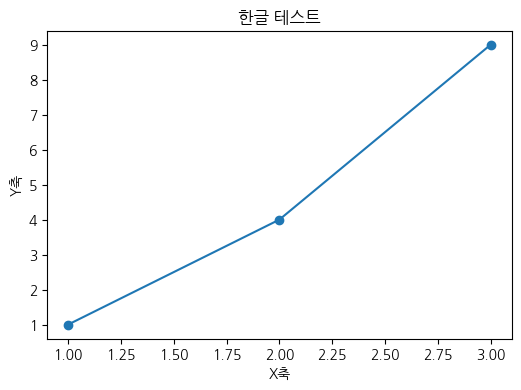

In [ ]:
# 1. Google Colab 환경에 한글 폰트(Nanum Gothic) 설치
!apt-get update -qq
!apt-get install -qq fonts-nanum

# 2. matplotlib 설정 변경
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 폰트 캐시 재생성 (폰트 리스트 업데이트)
# fm._rebuild()  # Remove this line
fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf') # Add this line to add the font

# Nanum Gothic 폰트가 설치되었는지 확인 (선택사항)
nanum_fonts = [f.name for f in fm.fontManager.ttflist if 'Nanum' in f.name]
print("설치된 Nanum 폰트:", nanum_fonts)

# matplotlib의 기본 폰트를 NanumGothic으로 설정
plt.rcParams['font.family'] = 'NanumGothic'
# 음수 기호가 깨지지 않도록 설정 (필수 아님)
plt.rcParams['axes.unicode_minus'] = False

# 3. 테스트: 한글이 포함된 그래프 출력
plt.figure(figsize=(6,4))
plt.title("한글 테스트")
plt.plot([1, 2, 3], [1, 4, 9], marker='o')
plt.xlabel("X축")
plt.ylabel("Y축")
plt.show()

In [ ]:
# 날짜 변환
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors='coerce')
df = df.sort_values('Date').dropna(subset=['Date']).reset_index(drop=True)

print("\n=== 데이터 상위 5행 ===")
print(df.head())
print("\n=== 데이터 info ===")
print(df.info())
print("\n=== 데이터 describe ===")
print(df.describe())
df.isna().sum()


=== 데이터 상위 5행 ===
        Date Cases       SO2        CO        O3       NO2       PM10  \
0 2020-02-01     1  0.003274  0.699089  0.026038  0.022698  63.185218   
1 2020-02-02     3  0.003502  0.748826  0.028493  0.020737  69.092334   
2 2020-02-03     0  0.003140  0.463362  0.029590  0.015894  32.560316   
3 2020-02-04     1  0.003329  0.465114  0.023674  0.019638  29.410079   
4 2020-02-05     5  0.003002  0.374520  0.029291  0.011450  22.960480   

        PM25  평균기온(℃)  평균최고기온(℃)  ...  최저기온(℃)  평균일강수량(mm)  최다일강수량(mm)  \
0  47.416719      2.2        7.8  ...     -6.8         0.0         0.2   
1  52.897434      2.1        7.8  ...    -11.2         0.0         0.7   
2  21.600817      1.3        5.7  ...     -9.7         0.0         0.7   
3  18.842018      0.1        6.3  ...    -18.6         0.3         2.0   
4  11.594881     -3.6        1.0  ...    -18.9         0.0        26.0   

   평균풍속(m/s)  최대풍속(m/s)  최대순간풍속(m/s)  평균습도(%rh)  최저습도(%rh)  일조합(hr)  \
0        1.5       12.5   

,0
Date,0
Cases,0
SO2,0
CO,0
O3,0
NO2,0
PM10,0
PM25,0
평균기온(℃),0
평균최고기온(℃),0


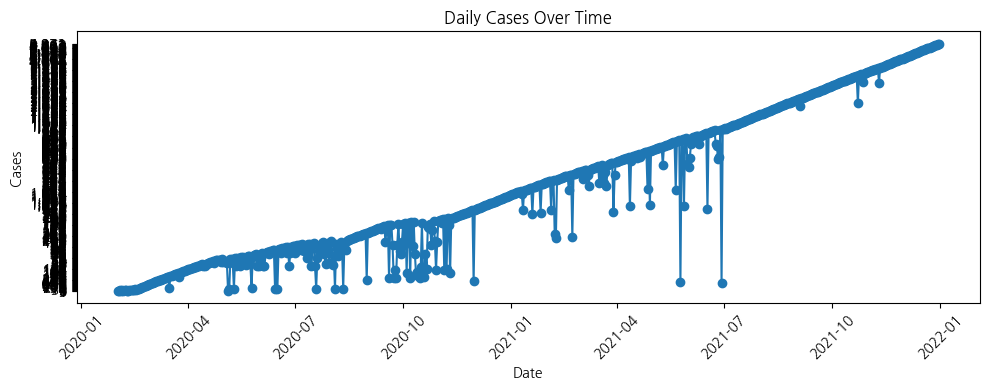

In [ ]:
# EDA 시각화(기본)
plt.figure(figsize=(10,4))
plt.plot(df['Date'], df['Cases'], marker='o')
plt.title("Daily Cases Over Time")
plt.xlabel("Date")
plt.ylabel("Cases")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

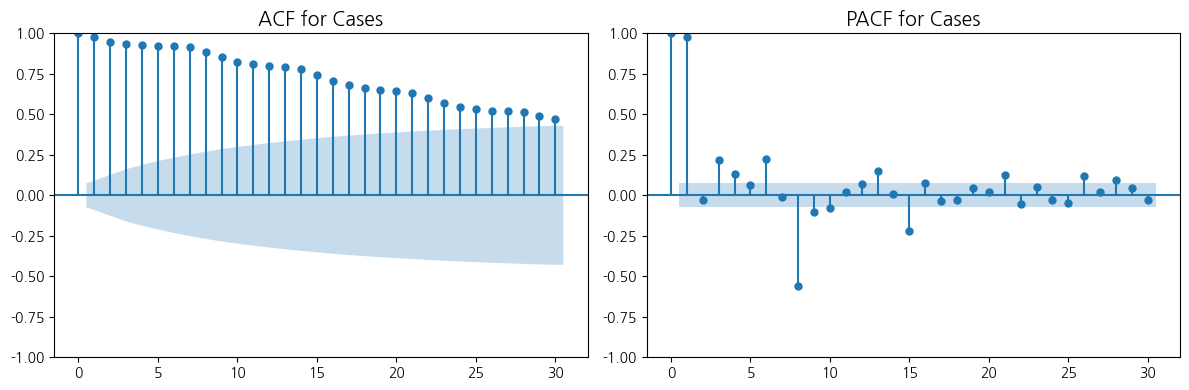

'\n- 위 그래프에서 천천히 줄어드는 패턴이 있다면 AR이나 MA 파라미터를 조정할 수 있는 근거가 된다.\n- 예를 들어 ACF가 서서히 감소한다면 AR 모델을, PACF가 급격히 절단(cut off)되는 패턴이면 AR 차수를\n  그 시점으로 추정할 수 있다.\n'

In [ ]:
########################################
# 3. ACF 및 PACF 분석
########################################
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import shap
"""
[ACF, PACF 분석]
1) ACF (Autocorrelation Function): 시계열 데이터의 자기상관을 다양한 시차(lag)에 대해 측정
2) PACF (Partial Autocorrelation Function): 특정 시차에서의 순수한 상관관계를 측정

이 분석을 통해 데이터가 ARIMA 모델에 적합한지, AR, MA 차수가 얼마인지 추정하는 데 도움을 줍니다.
"""
# df['Cases'] = pd.to_numeric(df['Cases'].str.replace(',', ''), errors='coerce')
#==========================================================
# (1) ACF, PACF 플롯을 통해 시계열 특성 파악하기
#==========================================================

fig, axes = plt.subplots(1, 2, figsize=(12,4))
plot_acf(df['Cases'].dropna(), ax=axes[0], lags=30)
axes[0].set_title("ACF for Cases", fontsize=14)
plot_pacf(df['Cases'].dropna(), ax=axes[1], lags=30, method='ywm')
axes[1].set_title("PACF for Cases", fontsize=14)
plt.tight_layout()
plt.show()

"""
- 위 그래프에서 천천히 줄어드는 패턴이 있다면 AR이나 MA 파라미터를 조정할 수 있는 근거가 된다.
- 예를 들어 ACF가 서서히 감소한다면 AR 모델을, PACF가 급격히 절단(cut off)되는 패턴이면 AR 차수를
  그 시점으로 추정할 수 있다.
"""

# 0205 16:30 피드백 추가. 가능하면 5일차의 변수를 추가할것
# features들을 줄이면서 한번 수정해볼 것
# 성능은 MAPE를 사용할 것


In [ ]:
########################################
########################################


# 'Cases_lag1', 'Cases_lag5', 'Cases_lag7', 'Cases_lag14', 'Cases_ma5', 'Cases_std5','Cases_ma7', 'Cases_std7', 'Cases_ma14', 'Cases_std14', 'Cases_diff', 'Cases_lag1_log', 'Cases_lag7_log', 'Cases_lag1_diff', 'Cases_diff2'
# 1,5,7,14일전 확진자수 생성(현재행의 바로 1,5,7,14 일 전 행 값으로 채워짐
# 이동 평균(Moving Average)과 이동 표준편차 생성 (7일/14일 단위)
for ws in [1,5,7,14]:

    df[f'Cases_lag{ws}'] = df['Cases'].shift(ws)
    # 최근 7일/14일 간의 평균 확진자 수 (데이터의 추세 파악용)
    if ws==5 or ws == 7 or ws == 14:
      # 최근 7일/14일 간의 평균 확진자 수 (데이터의 추세 파악용)
      df[f'Cases_ma{ws}'] = df['Cases'].rolling(ws).mean()
      # 최근 7일/14일 간의 확진자 수 표준편차 (데이터의 변동성 측정)
      df[f'Cases_std{ws}'] = df['Cases'].rolling(ws).std()



# 로그 변환: 확진자 수에 자연로그 적용 (큰 숫자의 스케일을 줄여 패턴 분석 용이)
# np.log1p는 log(1+x)로, 0 값이 있어도 계산 가능
df['Cases_log'] = np.log1p(df['Cases'])

# 1일 차분: 전일 대비 확진자 수 변화량 (어제 vs 오늘 증감 계산)
df['Cases_diff'] = df['Cases'].diff(1)

# 1일 전 확진자 수에 로그 변환 적용 (과거 데이터 스케일 조정)
df['Cases_lag1_log'] = np.log1p(df['Cases_lag1'])

# 7일 전 확진자 수에 로그 변환 적용 (과거 데이터 스케일 조정)
df['Cases_lag7_log'] = np.log1p(df['Cases_lag7'])

# 1일 전 확진자 수의 1일 차분 (이틀 전 vs 어제 증감 계산)
df['Cases_lag1_diff'] = df['Cases_lag1'].diff(1)

# 2차 차분: 1일 차분 데이터의 추가 차분 (변화량의 변화량, 추세 변화율 분석)
df['Cases_diff2'] = df['Cases_diff'].diff(1)


'''
차분(Diff): 전날 데이터와 현재 데이터의 차이 (예: 오늘 확진자 - 어제 확진자)

이동 평균(MA): 최근 N일 평균값으로 단기적 추세 파악

로그 변환: 숫자가 클 때 변동성 완화 (100 → 10,000 변화보다 1 → 100 변화가 더 극적임)

표준편차(Std): 데이터가 평균에서 얼마나 퍼져있는지 나타내는 지표

Lag(시차): 과거 데이터를 현재 시점으로 가져와 패턴 비교에 사용
'''

'\n차분(Diff): 전날 데이터와 현재 데이터의 차이 (예: 오늘 확진자 - 어제 확진자)\n\n이동 평균(MA): 최근 N일 평균값으로 단기적 추세 파악\n\n로그 변환: 숫자가 클 때 변동성 완화 (100 → 10,000 변화보다 1 → 100 변화가 더 극적임)\n\n표준편차(Std): 데이터가 평균에서 얼마나 퍼져있는지 나타내는 지표\n\nLag(시차): 과거 데이터를 현재 시점으로 가져와 패턴 비교에 사용\n'

In [ ]:
# 결측치 제거(shift/rolling 후 생긴)
df.isna().sum()

,0
Date,0
Cases,0
SO2,0
CO,0
O3,0
NO2,0
PM10,0
PM25,0
평균기온(℃),0
평균최고기온(℃),0


In [ ]:
df.dropna(inplace=True)

In [ ]:
# EDA(상관관계 히트맵)
cols_for_corr = [    "SO2", "CO", "O3", "NO2", "PM10", "PM25",
    "평균기온(℃)", "평균최고기온(℃)", "최고기온(℃)", "평균최저기온(℃)", "최저기온(℃)",
    "평균일강수량(mm)", "최다일강수량(mm)", "평균풍속(m/s)", "최대풍속(m/s)", "최대순간풍속(m/s)",
    "평균습도(%rh)", "최저습도(%rh)", "일조합(hr)", "일사합(MJ/m2)",
                     'Cases_lag1', 'Cases_lag5', 'Cases_lag7', 'Cases_lag14',
                     'Cases_ma5', 'Cases_std5','Cases_ma7', 'Cases_std7', 'Cases_ma14', 'Cases_std14',
                     'Cases_diff', 'Cases_lag1_log', 'Cases_lag7_log', 'Cases_lag1_diff', 'Cases_diff2',"Cases"]


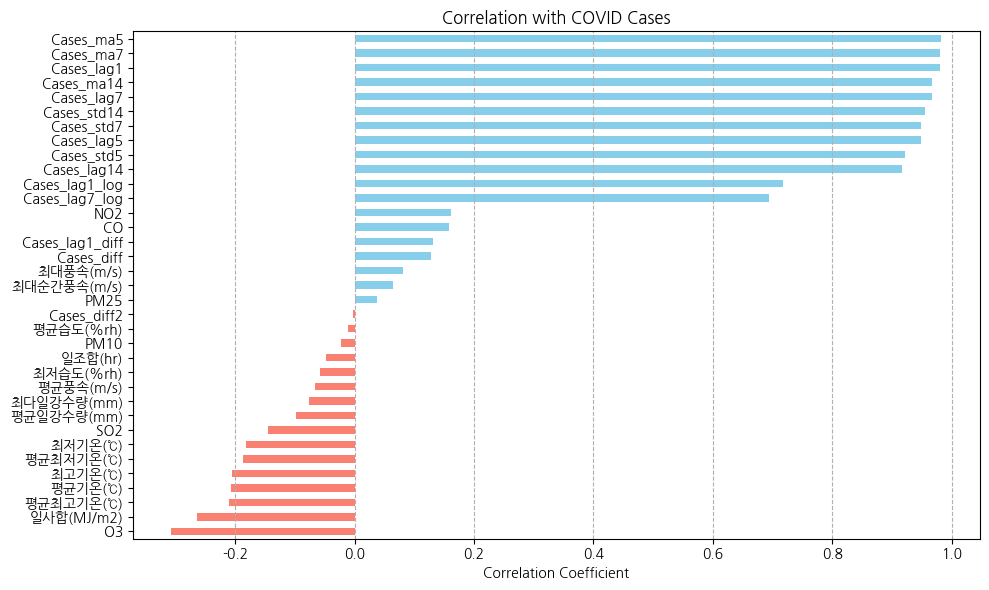

In [ ]:
# Cases와의 상관계수 추출 및 정렬
corr_with_cases = df[cols_for_corr].corr()['Cases'].drop('Cases').sort_values()

# 수평 막대 그래프
plt.figure(figsize=(10, 6))
corr_with_cases.plot(kind='barh', color=np.where(corr_with_cases >= 0, 'skyblue', 'salmon'))
plt.title("Correlation with COVID Cases")
plt.xlabel("Correlation Coefficient")
plt.grid(axis='x', linestyle='--')
plt.tight_layout()
plt.show()

# 'Cases_lag1', 'Cases_ma5', 'Cases_std5', 'Cases_ma7'

In [ ]:
########################################
# 4. Train/Val/Test 분할 (날짜 기준)
########################################
train_end_date = pd.to_datetime('2021-05-01')
val_end_date   = pd.to_datetime('2021-07-31')

train_df = df[df['Date'] < train_end_date]
val_df   = df[(df['Date']>=train_end_date)&(df['Date']<val_end_date)]
test_df  = df[df['Date'] >= val_end_date]

print(f"Train={train_df.shape}, Val={val_df.shape}, Test={test_df.shape}")

Train=(441, 38), Val=(91, 38), Test=(154, 38)


In [ ]:
rf_features = ["SO2", "CO", "O3", "NO2", "PM10", "PM25",
    "평균기온(℃)", "평균최고기온(℃)", "최고기온(℃)", "평균최저기온(℃)", "최저기온(℃)",
    "평균일강수량(mm)", "최다일강수량(mm)", "평균풍속(m/s)", "최대풍속(m/s)", "최대순간풍속(m/s)",
    "평균습도(%rh)", "최저습도(%rh)", "일조합(hr)", "일사합(MJ/m2)",
                     'Cases_lag1', 'Cases_lag5', 'Cases_lag7', 'Cases_lag14',
                     'Cases_ma5', 'Cases_std5','Cases_ma7', 'Cases_std7', 'Cases_ma14', 'Cases_std14',
                     'Cases_diff', 'Cases_lag1_log', 'Cases_lag7_log', 'Cases_lag1_diff', 'Cases_diff2']

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# VIF 계산

X = df.loc[:, rf_features]
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# 결과 출력
# !pip install ace_tools # This line is removed as 'ace_tools' is not available for public installation.
# import ace_tools as tools # This line is removed because 'ace_tools' is not available.
# tools.display_dataframe_to_user(name="VIF 결과", dataframe=vif_data) # This line is removed as it depends on 'ace_tools'.

# Instead, display the DataFrame directly using pandas:
print("VIF 결과:")
print(vif_data)  # Alternatively, use vif_data.head() to display the first few rows.

VIF 결과:
           Variable          VIF
0               SO2   223.517612
1                CO   278.167966
2                O3    39.576649
3               NO2    71.764626
4              PM10     9.238290
5              PM25    33.591530
6           평균기온(℃)  2333.273413
7         평균최고기온(℃)  1448.253725
8           최고기온(℃)   539.126948
9         평균최저기온(℃)   504.308336
10          최저기온(℃)    57.429359
11       평균일강수량(mm)     4.278347
12       최다일강수량(mm)     5.242939
13        평균풍속(m/s)    35.376388
14        최대풍속(m/s)    65.405662
15      최대순간풍속(m/s)    94.858912
16        평균습도(%rh)   180.419924
17        최저습도(%rh)    27.733710
18          일조합(hr)    57.798578
19       일사합(MJ/m2)    90.293487
20       Cases_lag1   533.884182
21       Cases_lag5   281.902437
22       Cases_lag7   145.036434
23      Cases_lag14    94.499789
24        Cases_ma5  2911.104121
25       Cases_std5    21.981320
26        Cases_ma7  5854.022223
27       Cases_std7    52.289138
28       Cases_ma14  1495.591645
29

/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


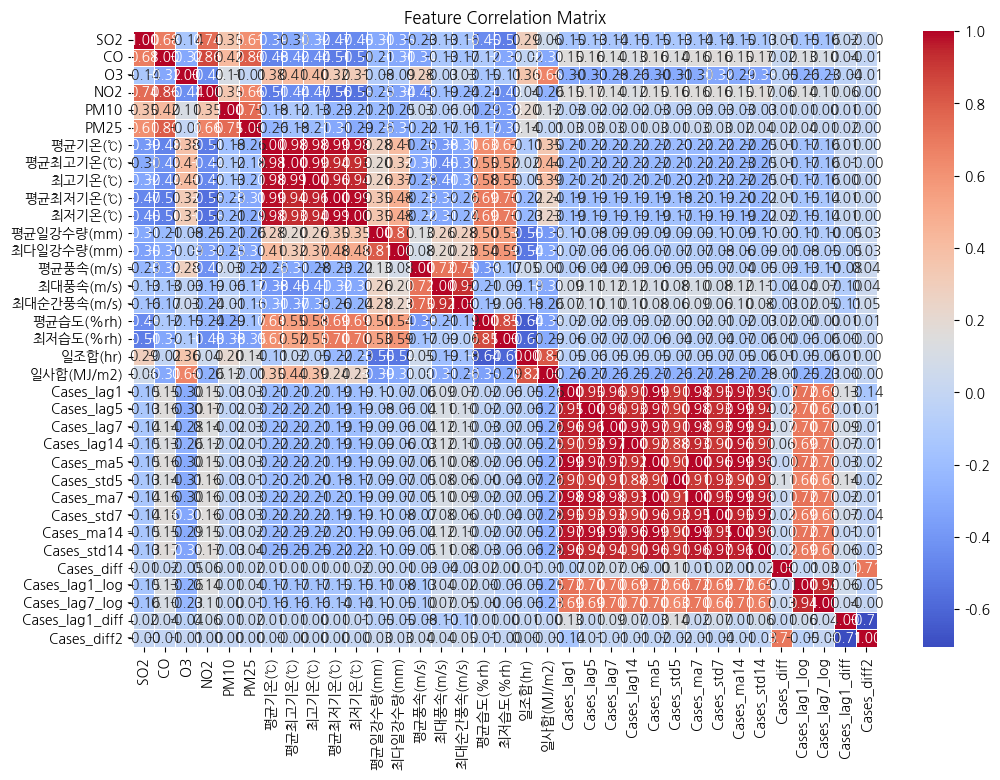

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 상관계수 행렬 계산
corr_matrix = X.corr()

# 히트맵 그리기
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()


In [ ]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 선택된 변수 목록 (다중공선성이 높은 변수는 미리 제거한 상태)
selected_cols = [ "PM10",
    "평균기온(℃)",
    "평균일강수량(mm)", "최다일강수량(mm)", "평균풍속(m/s)",
    "평균습도(%rh)", "일조합(hr)", "일사합(MJ/m2)",
                      'Cases_std5',
                      ]


# 데이터 준비: 결측치 제거
X_selected = df[selected_cols].dropna()

# VIF 계산 함수 정의
def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df["Variable"] = data.columns
    vif_df["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_df

# 초기 VIF 계산
vif_initial = calculate_vif(X_selected)
print("초기 VIF 결과:")
print(vif_initial)

# VIF 임계값 설정 (예: 10 이상이면 문제 있다고 판단)
threshold = 10
high_vif_vars = vif_initial[vif_initial["VIF"] >= threshold]["Variable"].tolist()

if high_vif_vars:
    print("\n다음 변수들은 VIF가 {} 이상입니다. 제거 또는 조정이 필요합니다:".format(threshold))
    print(high_vif_vars)
else:
    print("\n모든 변수의 VIF가 {} 미만입니다.".format(threshold))

# 필요에 따라 고 VIF 변수 제거 후 VIF 재계산
X_adjusted = X_selected.drop(columns=high_vif_vars)
vif_adjusted = calculate_vif(X_adjusted)

print("\n고 VIF 변수를 제거한 후의 VIF 결과:")
print(vif_adjusted)

초기 VIF 결과:
     Variable        VIF
0        PM10   2.924372
1     평균기온(℃)  14.406837
2  평균일강수량(mm)   3.741857
3  최다일강수량(mm)   4.573529
4   평균풍속(m/s)   8.770526
5   평균습도(%rh)  16.295535
6     일조합(hr)  33.833601
7  일사합(MJ/m2)  56.550072
8  Cases_std5   1.708610

다음 변수들은 VIF가 10 이상입니다. 제거 또는 조정이 필요합니다:
['평균기온(℃)', '평균습도(%rh)', '일조합(hr)', '일사합(MJ/m2)']

고 VIF 변수를 제거한 후의 VIF 결과:
     Variable       VIF
0        PM10  2.453173
1  평균일강수량(mm)  3.332314
2  최다일강수량(mm)  3.722709
3   평균풍속(m/s)  3.256263
4  Cases_std5  1.351492


In [ ]:
rf_features = ["평균일강수량(mm)", "최다일강수량(mm)", '평균기온(℃)', 'PM10', "Cases_lag1", "Cases_lag5"]
# rf_features = ["평균일강수량(mm)", "최다일강수량(mm)", '평균기온(℃)', 'PM10', "Cases_lag1", "Cases_lag5"] MAE=4.163, RMSE=6.921, R2=0.632


In [ ]:
features = rf_features

In [ ]:
########################################
# 5. 랜덤 포레스트 (회귀)
########################################

X_train_rf = train_df[rf_features]
y_train_rf = train_df['Cases']
X_val_rf   = val_df[rf_features]
y_val_rf   = val_df['Cases']
X_test_rf  = test_df[rf_features]
y_test_rf  = test_df['Cases']

# TimeSeriesSplit + GridSearchCV
rf_params = {
    'n_estimators':[50,100],
    'max_depth':[3,5,7],
    'min_samples_leaf':[1,3,5]
}
tscv = TimeSeriesSplit(n_splits=3)

# print("\n[RandomForest] GridSearch...")
# rf_grid = GridSearchCV(
#     estimator=RandomForestRegressor(random_state=42),
#     param_grid=rf_params,
#     scoring='neg_mean_absolute_error',
#     cv=tscv,
#     n_jobs=-1,
#     verbose=1
# )
# rf_grid.fit(X_train_rf, y_train_rf)

# best_rf = rf_grid.best_estimator_


# # Feature Importance 확인 및 시각화 (추가 코드)
# feature_importances = pd.Series(best_rf.feature_importances_, index=rf_features).sort_values(ascending=False)

# print("\n[RandomForest] Feature Importances:")
# print(feature_importances)
# # Validation
# val_pred_rf = best_rf.predict(X_val_rf)
# val_mae_rf = mean_absolute_error(y_val_rf, val_pred_rf)
# print("[RF] val MAE=", val_mae_rf)

# # Test
# y_pred_rf = best_rf.predict(X_test_rf)
# rf_mae = mean_absolute_error(y_test_rf, y_pred_rf)
# rf_rmse = np.sqrt(mean_squared_error(y_test_rf, y_pred_rf))
# rf_r2 = r2_score(y_test_rf, y_pred_rf)
# print("[RF on Test] MAE=%.3f, RMSE=%.3f, R2=%.3f" % (rf_mae, rf_rmse, rf_r2))

# Optuna objective 함수 정의
def objective(trial):
    # 하이퍼파라미터 : 기존 그리드 서치 값과 동일한 범주형 옵션 사용
    n_estimators = trial.suggest_categorical("n_estimators", [50, 100])
    max_depth = trial.suggest_categorical("max_depth", [1,2,3,4,5,6,7])
    min_samples_leaf = trial.suggest_categorical("min_samples_leaf", [1,2,3,4,5])

    # 모델 생성
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        n_jobs=-1
    )

    # TimeSeriesSplit를 이용한 교차검증 (n_splits=3)
    tscv = TimeSeriesSplit(n_splits=3)
    mae_list = []
    for train_index, val_index in tscv.split(X_train_rf):
        X_train_cv = X_train_rf.iloc[train_index]
        y_train_cv = y_train_rf.iloc[train_index]
        X_val_cv   = X_train_rf.iloc[val_index]
        y_val_cv   = y_train_rf.iloc[val_index]

        model.fit(X_train_cv, y_train_cv)
        preds = model.predict(X_val_cv)
        mae = mean_absolute_error(y_val_cv, preds)
        mae_list.append(mae)

    # 평균 MAE 반환 (낮을수록 좋은 모델)
    return np.mean(mae_list)

# Optuna 스터디 생성 및 최적화 실행 (n_trials=20; 필요시 조정)
print("\n[RandomForest] Optuna 최적화 시작...")
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# 최적의 하이퍼파라미터 출력
print("\n[RandomForest] 최적의 trial:")
print("평균 MAE:", study.best_trial.value)
print("최적 하이퍼파라미터:", study.best_trial.params)

# 최적 하이퍼파라미터를 사용하여 모델 재학습
best_params = study.best_trial.params
best_rf = RandomForestRegressor(
    n_estimators=best_params["n_estimators"],
    max_depth=best_params["max_depth"],
    min_samples_leaf=best_params["min_samples_leaf"],
    random_state=42,
    n_jobs=-1
)
best_rf.fit(X_train_rf, y_train_rf)

# Feature Importance 확인 및 출력
feature_importances = pd.Series(best_rf.feature_importances_, index=rf_features).sort_values(ascending=False)
print("\n[RandomForest] Feature Importances:")
print(feature_importances)

# Validation 데이터 평가
val_pred_rf = best_rf.predict(X_val_rf)
val_mae_rf = mean_absolute_error(y_val_rf, val_pred_rf)
print("[RF] Validation MAE =", val_mae_rf)

# Test 데이터 평가
y_pred_rf = best_rf.predict(X_test_rf)
rf_mae = mean_absolute_error(y_test_rf, y_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y_test_rf, y_pred_rf))
rf_r2 = r2_score(y_test_rf, y_pred_rf)
rf_mape = np.mean(np.abs((y_test_rf - y_pred_rf) / y_test_rf))
print("[RF on Test] MAE=%.3f, RMSE=%.3f, R2=%.3f, MAPE=%.3f%%" % (rf_mae, rf_rmse, rf_r2, rf_mape))

[I 2025-02-06 02:03:54,420] A new study created in memory with name: no-name-9f2f808d-b116-444c-8f02-aad4d5cd5d53



[RandomForest] Optuna 최적화 시작...


[I 2025-02-06 02:03:54,913] Trial 0 finished with value: 1.5201119676282204 and parameters: {'n_estimators': 50, 'max_depth': 1, 'min_samples_leaf': 2}. Best is trial 0 with value: 1.5201119676282204.
[I 2025-02-06 02:03:55,664] Trial 1 finished with value: 1.5163315183662904 and parameters: {'n_estimators': 100, 'max_depth': 6, 'min_samples_leaf': 2}. Best is trial 1 with value: 1.5163315183662904.
[I 2025-02-06 02:03:56,308] Trial 2 finished with value: 1.6113446082256757 and parameters: {'n_estimators': 100, 'max_depth': 1, 'min_samples_leaf': 5}. Best is trial 1 with value: 1.5163315183662904.
[I 2025-02-06 02:03:56,964] Trial 3 finished with value: 1.5328141493815288 and parameters: {'n_estimators': 100, 'max_depth': 7, 'min_samples_leaf': 2}. Best is trial 1 with value: 1.5163315183662904.
[I 2025-02-06 02:03:57,337] Trial 4 finished with value: 1.5661807300927226 and parameters: {'n_estimators': 50, 'max_depth': 4, 'min_samples_leaf': 5}. Best is trial 1 with value: 1.5163315183


[RandomForest] 최적의 trial:
평균 MAE: 1.4246000276528619
최적 하이퍼파라미터: {'n_estimators': 100, 'max_depth': 3, 'min_samples_leaf': 1}

[RandomForest] Feature Importances:
Cases_lag1    0.814701
Cases_lag5    0.053744
최다일강수량(mm)    0.044520
PM10          0.043712
평균기온(℃)       0.039798
평균일강수량(mm)    0.003526
dtype: float64
[RF] Validation MAE = 6.721087092802218
[RF on Test] MAE=4.163, RMSE=6.921, R2=0.632, MAPE=0.380%


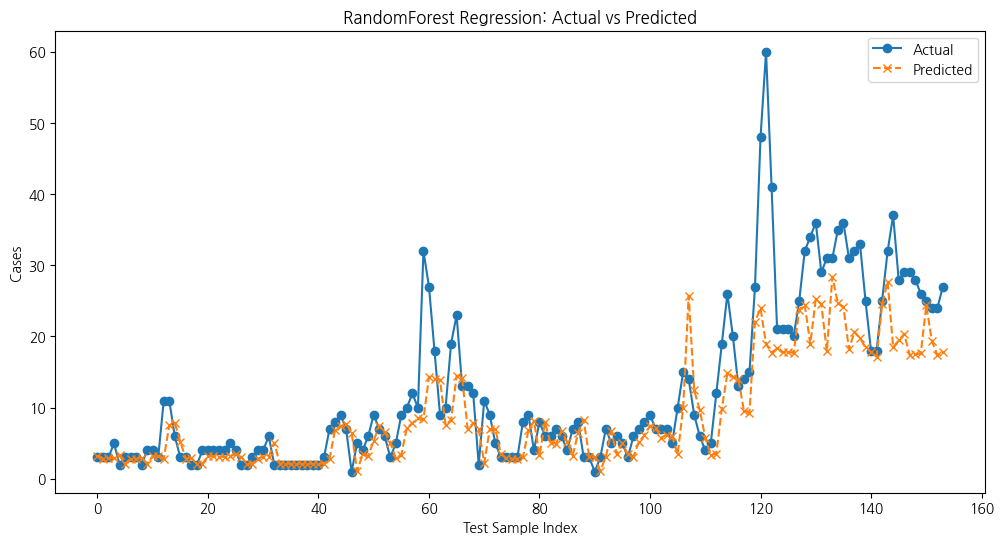

In [ ]:
########################################
# RandomForest 시각화 (Loss 추이 & 예측 결과)
########################################
# 테스트셋 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test_rf)), y_test_rf, label='Actual', marker='o', linestyle='-')
plt.plot(range(len(y_test_rf)), y_pred_rf, label='Predicted', marker='x', linestyle='--')
plt.xlabel("Test Sample Index")
plt.ylabel("Cases")
plt.title("RandomForest Regression: Actual vs Predicted")
plt.legend()
plt.show()


In [ ]:
original_features = ["PM10",
    "평균기온(℃)",
    "평균일강수량(mm)", "최다일강수량(mm)", "평균풍속(m/s)",
    "평균습도(%rh)",  "일조합(hr)",
                     'Cases_lag1',
                     'Cases_ma5','Cases_std14',
                     ]

In [ ]:
########################################
# 6. SARIMAX (ARIMAX)
########################################
sarimax_exog = original_features
y_train_sar = train_df['Cases']
y_test_sar  = test_df['Cases']
X_train_sar = train_df[sarimax_exog]
X_test_sar  = test_df[sarimax_exog]



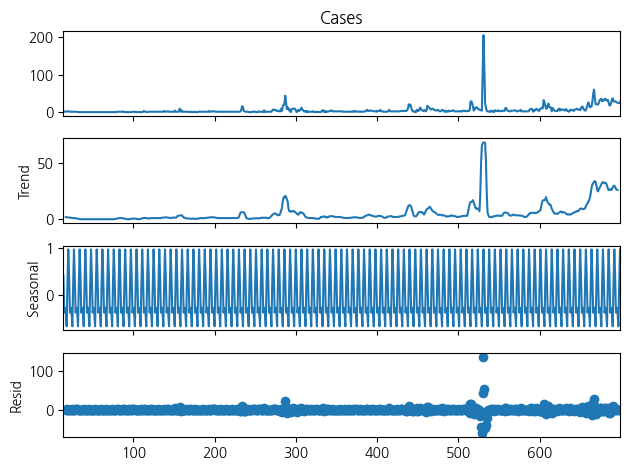

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(
    x=df['Cases'],    # 시계열 데이터
    model='additive', # 또는 'multiplicative'
    period=7       # 가정하는 주기(예: 7일)
)
result.plot()
plt.show()

In [ ]:
sar_model = sm.tsa.statespace.SARIMAX(
    endog=y_train_sar,
    exog=X_train_sar,
    order=(1,0,1),
    seasonal_order=(0,0,1,7),
    enforce_stationarity=False,
    enforce_invertibility=False
)
sar_result = sar_model.fit(disp=False)
print(sar_result.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                             Cases   No. Observations:                  441
Model:             SARIMAX(1, 0, 1)x(0, 0, 1, 7)   Log Likelihood                -848.591
Date:                           Thu, 06 Feb 2025   AIC                           1725.182
Time:                                   02:18:10   BIC                           1782.140
Sample:                                        0   HQIC                          1747.668
                                           - 441                                         
Covariance Type:                             opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
PM10           -0.0009      0.002     -0.516      0.606      -0.004       0.002
평균기온(℃)        -0.0326      0.048     -0

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
import itertools
import numpy as np
import statsmodels.api as sm

# 파라미터 후보 범위 설정
# (p, d, q) 각각 0~2까지의 값을 후보로 예시 설정 (문제 특성에 따라 범위 조정 가능)
p = d = q = range(0, 3)

# 계절성 파라미터 (P, D, Q)도 비슷하게 후보로 설정하고, 계절 주기는 7 (예: 주간 주기)
seasonal_p = seasonal_d = seasonal_q = range(0, 2)
seasonal_period = 7

# 최적의 파라미터를 저장할 변수 초기화
best_aic = np.inf
best_order = None
best_seasonal_order = None

# 모든 후보 조합에 대해 반복 수행
for order in itertools.product(p, d, q):
    for seasonal_order_tuple in itertools.product(seasonal_p, seasonal_d, seasonal_q):
        # seasonal_order는 (P, D, Q, s) 형태로 설정됨
        seasonal_order = seasonal_order_tuple + (seasonal_period,)
        try:
            # SARIMAX 모델 생성
            sar_model = sm.tsa.statespace.SARIMAX(
                endog=y_train_sar,       # 타깃 변수 (예: 훈련 데이터)
                exog=X_train_sar,        # 외생 변수 (예: 훈련 데이터)
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            # 모델 피팅 (disp=False로 피팅 결과 출력 생략)
            sar_result = sar_model.fit(disp=False)

            # AIC가 낮을수록 좋은 모델이므로, 최적의 파라미터 찾기
            if sar_result.aic < best_aic:
                best_aic = sar_result.aic
                best_order = order
                best_seasonal_order = seasonal_order
            print(f"Tested order={order}, seasonal_order={seasonal_order}, AIC={sar_result.aic:.2f}")
        except Exception as e:
            # 모델 피팅 중 오류가 발생하는 경우 무시하고 다음 조합 진행
            print(f"Skipped order={order}, seasonal_order={seasonal_order} due to error: {e}")
            continue

# 최적의 파라미터 출력
print("\n최적의 파라미터 결과:")
print("Best AIC:", best_aic)
print("Best Order:", best_order)
print("Best Seasonal Order:", best_seasonal_order)


'''
Best AIC: 1725.1817073862617
Best Order: (1, 0, 1)
Best Seasonal Order: (0, 0, 1, 7)
'''

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(0, 0, 0), seasonal_order=(0, 0, 0, 7), AIC=2006.19


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of

Tested order=(0, 0, 0), seasonal_order=(0, 0, 1, 7), AIC=1959.07
Tested order=(0, 0, 0), seasonal_order=(0, 1, 0, 7), AIC=2336.16


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of

Tested order=(0, 0, 0), seasonal_order=(0, 1, 1, 7), AIC=1982.02


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(0, 0, 0), seasonal_order=(1, 0, 0, 7), AIC=1963.47


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(0, 0, 0), seasonal_order=(1, 0, 1, 7), AIC=1961.05


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested order=(0, 0, 0), seasonal_order=(1, 1, 0, 7), AIC=2139.68


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested order=(0, 0, 0), seasonal_order=(1, 1, 1, 7), AIC=1964.66


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of

Tested order=(0, 0, 1), seasonal_order=(0, 0, 0, 7), AIC=1844.55


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(0, 0, 1), seasonal_order=(0, 0, 1, 7), AIC=1803.22


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(0, 0, 1), seasonal_order=(0, 1, 0, 7), AIC=2162.87


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(0, 0, 1), seasonal_order=(0, 1, 1, 7), AIC=1811.06


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(0, 0, 1), seasonal_order=(1, 0, 0, 7), AIC=1811.18


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(0, 0, 1), seasonal_order=(1, 0, 1, 7), AIC=1800.65


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested order=(0, 0, 1), seasonal_order=(1, 1, 0, 7), AIC=1964.27


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of

Tested order=(0, 0, 1), seasonal_order=(1, 1, 1, 7), AIC=1811.70


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(0, 0, 2), seasonal_order=(0, 0, 0, 7), AIC=1789.56


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(0, 0, 2), seasonal_order=(0, 0, 1, 7), AIC=1754.73


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(0, 0, 2), seasonal_order=(0, 1, 0, 7), AIC=2090.63


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(0, 0, 2), seasonal_order=(0, 1, 1, 7), AIC=1750.21


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(0, 0, 2), seasonal_order=(1, 0, 0, 7), AIC=1759.78


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(0, 0, 2), seasonal_order=(1, 0, 1, 7), AIC=1755.31


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(0, 0, 2), seasonal_order=(1, 1, 0, 7), AIC=1926.78


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(0, 0, 2), seasonal_order=(1, 1, 1, 7), AIC=1753.84
Tested order=(0, 1, 0), seasonal_order=(0, 0, 0, 7), AIC=1925.75


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of

Tested order=(0, 1, 0), seasonal_order=(0, 0, 1, 7), AIC=1884.60
Tested order=(0, 1, 0), seasonal_order=(0, 1, 0, 7), AIC=2256.38


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested order=(0, 1, 0), seasonal_order=(0, 1, 1, 7), AIC=1903.43


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of

Tested order=(0, 1, 0), seasonal_order=(1, 0, 0, 7), AIC=1890.92


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(0, 1, 0), seasonal_order=(1, 0, 1, 7), AIC=1886.47


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(0, 1, 0), seasonal_order=(1, 1, 0, 7), AIC=2081.22


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(0, 1, 0), seasonal_order=(1, 1, 1, 7), AIC=1893.79


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(0, 1, 1), seasonal_order=(0, 0, 0, 7), AIC=1844.85


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(0, 1, 1), seasonal_order=(0, 0, 1, 7), AIC=1816.37


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(0, 1, 1), seasonal_order=(0, 1, 0, 7), AIC=2153.76


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(0, 1, 1), seasonal_order=(0, 1, 1, 7), AIC=1825.57


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(0, 1, 1), seasonal_order=(1, 0, 0, 7), AIC=1823.98


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(0, 1, 1), seasonal_order=(1, 0, 1, 7), AIC=1818.42


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(0, 1, 1), seasonal_order=(1, 1, 0, 7), AIC=1992.11


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(0, 1, 1), seasonal_order=(1, 1, 1, 7), AIC=1824.25


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(0, 1, 2), seasonal_order=(0, 0, 0, 7), AIC=1814.45


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(0, 1, 2), seasonal_order=(0, 0, 1, 7), AIC=1783.64


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(0, 1, 2), seasonal_order=(0, 1, 0, 7), AIC=2133.71


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(0, 1, 2), seasonal_order=(0, 1, 1, 7), AIC=1799.77


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(0, 1, 2), seasonal_order=(1, 0, 0, 7), AIC=1793.74


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(0, 1, 2), seasonal_order=(1, 0, 1, 7), AIC=1787.12


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested order=(0, 1, 2), seasonal_order=(1, 1, 0, 7), AIC=1977.36


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of

Tested order=(0, 1, 2), seasonal_order=(1, 1, 1, 7), AIC=1795.38
Tested order=(0, 2, 0), seasonal_order=(0, 0, 0, 7), AIC=2018.62


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of

Tested order=(0, 2, 0), seasonal_order=(0, 0, 1, 7), AIC=1974.14


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(0, 2, 0), seasonal_order=(0, 1, 0, 7), AIC=2355.03


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(0, 2, 0), seasonal_order=(0, 1, 1, 7), AIC=1993.02


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(0, 2, 0), seasonal_order=(1, 0, 0, 7), AIC=1977.84


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(0, 2, 0), seasonal_order=(1, 0, 1, 7), AIC=1976.08


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested order=(0, 2, 0), seasonal_order=(1, 1, 0, 7), AIC=2151.50


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of

Tested order=(0, 2, 0), seasonal_order=(1, 1, 1, 7), AIC=1978.14


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(0, 2, 1), seasonal_order=(0, 0, 0, 7), AIC=1928.04


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(0, 2, 1), seasonal_order=(0, 0, 1, 7), AIC=1953.39


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(0, 2, 1), seasonal_order=(0, 1, 0, 7), AIC=2256.95


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested order=(0, 2, 1), seasonal_order=(0, 1, 1, 7), AIC=1976.71


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of

Tested order=(0, 2, 1), seasonal_order=(1, 0, 0, 7), AIC=1953.01


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(0, 2, 1), seasonal_order=(1, 0, 1, 7), AIC=1909.32


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(0, 2, 1), seasonal_order=(1, 1, 0, 7), AIC=2152.05


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested order=(0, 2, 1), seasonal_order=(1, 1, 1, 7), AIC=1970.24


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of

Tested order=(0, 2, 2), seasonal_order=(0, 0, 0, 7), AIC=1847.60


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested order=(0, 2, 2), seasonal_order=(0, 0, 1, 7), AIC=1818.39


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested order=(0, 2, 2), seasonal_order=(0, 1, 0, 7), AIC=2160.15


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested order=(0, 2, 2), seasonal_order=(0, 1, 1, 7), AIC=1832.96


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of

Tested order=(0, 2, 2), seasonal_order=(1, 0, 0, 7), AIC=1829.92


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(0, 2, 2), seasonal_order=(1, 0, 1, 7), AIC=1820.83


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested order=(0, 2, 2), seasonal_order=(1, 1, 0, 7), AIC=2001.61


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested order=(0, 2, 2), seasonal_order=(1, 1, 1, 7), AIC=1831.12


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of

Tested order=(1, 0, 0), seasonal_order=(0, 0, 0, 7), AIC=1896.47


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(1, 0, 0), seasonal_order=(0, 0, 1, 7), AIC=1860.65


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(1, 0, 0), seasonal_order=(0, 1, 0, 7), AIC=2216.19


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(1, 0, 0), seasonal_order=(0, 1, 1, 7), AIC=1876.55


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(1, 0, 0), seasonal_order=(1, 0, 0, 7), AIC=1861.64


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(1, 0, 0), seasonal_order=(1, 0, 1, 7), AIC=1862.99


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested order=(1, 0, 0), seasonal_order=(1, 1, 0, 7), AIC=2039.42


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of

Tested order=(1, 0, 0), seasonal_order=(1, 1, 1, 7), AIC=1868.32


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(1, 0, 1), seasonal_order=(0, 0, 0, 7), AIC=1763.12


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(1, 0, 1), seasonal_order=(0, 0, 1, 7), AIC=1725.18


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(1, 0, 1), seasonal_order=(0, 1, 0, 7), AIC=2066.42


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(1, 0, 1), seasonal_order=(0, 1, 1, 7), AIC=1738.67


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(1, 0, 1), seasonal_order=(1, 0, 0, 7), AIC=1734.87


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(1, 0, 1), seasonal_order=(1, 0, 1, 7), AIC=1747.04


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(1, 0, 1), seasonal_order=(1, 1, 0, 7), AIC=1900.19


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(1, 0, 1), seasonal_order=(1, 1, 1, 7), AIC=1734.04


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(1, 0, 2), seasonal_order=(0, 0, 0, 7), AIC=1756.53


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(1, 0, 2), seasonal_order=(0, 0, 1, 7), AIC=1731.77


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(1, 0, 2), seasonal_order=(0, 1, 0, 7), AIC=2074.74


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(1, 0, 2), seasonal_order=(0, 1, 1, 7), AIC=1730.19


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(1, 0, 2), seasonal_order=(1, 0, 0, 7), AIC=1736.45


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(1, 0, 2), seasonal_order=(1, 0, 1, 7), AIC=1739.44


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(1, 0, 2), seasonal_order=(1, 1, 0, 7), AIC=1905.94


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested order=(1, 0, 2), seasonal_order=(1, 1, 1, 7), AIC=1732.30


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of

Tested order=(1, 1, 0), seasonal_order=(0, 0, 0, 7), AIC=1887.60


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(1, 1, 0), seasonal_order=(0, 0, 1, 7), AIC=1845.88


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(1, 1, 0), seasonal_order=(0, 1, 0, 7), AIC=2224.62


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(1, 1, 0), seasonal_order=(0, 1, 1, 7), AIC=1867.51


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(1, 1, 0), seasonal_order=(1, 0, 0, 7), AIC=1847.51


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(1, 1, 0), seasonal_order=(1, 0, 1, 7), AIC=1847.95


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested order=(1, 1, 0), seasonal_order=(1, 1, 0, 7), AIC=2033.63


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of

Tested order=(1, 1, 0), seasonal_order=(1, 1, 1, 7), AIC=1857.48


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(1, 1, 1), seasonal_order=(0, 0, 0, 7), AIC=1819.70


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(1, 1, 1), seasonal_order=(0, 0, 1, 7), AIC=1789.64


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(1, 1, 1), seasonal_order=(0, 1, 0, 7), AIC=2138.90


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(1, 1, 1), seasonal_order=(0, 1, 1, 7), AIC=1803.17


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(1, 1, 1), seasonal_order=(1, 0, 0, 7), AIC=1794.90


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(1, 1, 1), seasonal_order=(1, 0, 1, 7), AIC=1790.96


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(1, 1, 1), seasonal_order=(1, 1, 0, 7), AIC=1969.39


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(1, 1, 1), seasonal_order=(1, 1, 1, 7), AIC=1802.38


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(1, 1, 2), seasonal_order=(0, 0, 0, 7), AIC=1817.83


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(1, 1, 2), seasonal_order=(0, 0, 1, 7), AIC=1787.39


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(1, 1, 2), seasonal_order=(0, 1, 0, 7), AIC=2137.98


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(1, 1, 2), seasonal_order=(0, 1, 1, 7), AIC=1800.56


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(1, 1, 2), seasonal_order=(1, 0, 0, 7), AIC=1795.14


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(1, 1, 2), seasonal_order=(1, 0, 1, 7), AIC=1787.28


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(1, 1, 2), seasonal_order=(1, 1, 0, 7), AIC=1968.31


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested order=(1, 1, 2), seasonal_order=(1, 1, 1, 7), AIC=1795.02


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of

Tested order=(1, 2, 0), seasonal_order=(0, 0, 0, 7), AIC=2017.64


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(1, 2, 0), seasonal_order=(0, 0, 1, 7), AIC=1972.35


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(1, 2, 0), seasonal_order=(0, 1, 0, 7), AIC=2354.73


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(1, 2, 0), seasonal_order=(0, 1, 1, 7), AIC=1992.71


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(1, 2, 0), seasonal_order=(1, 0, 0, 7), AIC=1972.77


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(1, 2, 0), seasonal_order=(1, 0, 1, 7), AIC=1974.14


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested order=(1, 2, 0), seasonal_order=(1, 1, 0, 7), AIC=2148.73


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of

Tested order=(1, 2, 0), seasonal_order=(1, 1, 1, 7), AIC=1977.09


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(1, 2, 1), seasonal_order=(0, 0, 0, 7), AIC=1888.26


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(1, 2, 1), seasonal_order=(0, 0, 1, 7), AIC=1847.55


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(1, 2, 1), seasonal_order=(0, 1, 0, 7), AIC=2222.73


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested order=(1, 2, 1), seasonal_order=(0, 1, 1, 7), AIC=1873.35


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of

Tested order=(1, 2, 1), seasonal_order=(1, 0, 0, 7), AIC=1852.09


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(1, 2, 1), seasonal_order=(1, 0, 1, 7), AIC=1850.34


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(1, 2, 1), seasonal_order=(1, 1, 0, 7), AIC=2035.66


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(1, 2, 1), seasonal_order=(1, 1, 1, 7), AIC=1877.59


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(1, 2, 2), seasonal_order=(0, 0, 0, 7), AIC=1824.31


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested order=(1, 2, 2), seasonal_order=(0, 0, 1, 7), AIC=1792.95


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of

Tested order=(1, 2, 2), seasonal_order=(0, 1, 0, 7), AIC=2189.11


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested order=(1, 2, 2), seasonal_order=(0, 1, 1, 7), AIC=1876.51


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of

Tested order=(1, 2, 2), seasonal_order=(1, 0, 0, 7), AIC=1801.18


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(1, 2, 2), seasonal_order=(1, 0, 1, 7), AIC=1799.84


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested order=(1, 2, 2), seasonal_order=(1, 1, 0, 7), AIC=2039.96


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested order=(1, 2, 2), seasonal_order=(1, 1, 1, 7), AIC=1880.88


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of

Tested order=(2, 0, 0), seasonal_order=(0, 0, 0, 7), AIC=1825.57


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(2, 0, 0), seasonal_order=(0, 0, 1, 7), AIC=1789.17


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(2, 0, 0), seasonal_order=(0, 1, 0, 7), AIC=2142.90


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested order=(2, 0, 0), seasonal_order=(0, 1, 1, 7), AIC=1807.12


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of

Tested order=(2, 0, 0), seasonal_order=(1, 0, 0, 7), AIC=1784.13


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(2, 0, 0), seasonal_order=(1, 0, 1, 7), AIC=1789.04


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(2, 0, 0), seasonal_order=(1, 1, 0, 7), AIC=1964.46


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(2, 0, 0), seasonal_order=(1, 1, 1, 7), AIC=1790.45


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(2, 0, 1), seasonal_order=(0, 0, 0, 7), AIC=1834.39


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(2, 0, 1), seasonal_order=(0, 0, 1, 7), AIC=1807.17


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(2, 0, 1), seasonal_order=(0, 1, 0, 7), AIC=2132.41


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(2, 0, 1), seasonal_order=(0, 1, 1, 7), AIC=1802.30


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(2, 0, 1), seasonal_order=(1, 0, 0, 7), AIC=1821.90


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(2, 0, 1), seasonal_order=(1, 0, 1, 7), AIC=1822.22


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(2, 0, 1), seasonal_order=(1, 1, 0, 7), AIC=1956.30


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested order=(2, 0, 1), seasonal_order=(1, 1, 1, 7), AIC=1809.32


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of

Tested order=(2, 0, 2), seasonal_order=(0, 0, 0, 7), AIC=1777.15


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(2, 0, 2), seasonal_order=(0, 0, 1, 7), AIC=1756.20


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(2, 0, 2), seasonal_order=(0, 1, 0, 7), AIC=2088.62


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(2, 0, 2), seasonal_order=(0, 1, 1, 7), AIC=1741.31


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(2, 0, 2), seasonal_order=(1, 0, 0, 7), AIC=1746.32


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(2, 0, 2), seasonal_order=(1, 0, 1, 7), AIC=1750.40


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(2, 0, 2), seasonal_order=(1, 1, 0, 7), AIC=1902.12


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested order=(2, 0, 2), seasonal_order=(1, 1, 1, 7), AIC=1734.52


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of

Tested order=(2, 1, 0), seasonal_order=(0, 0, 0, 7), AIC=1864.33


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(2, 1, 0), seasonal_order=(0, 0, 1, 7), AIC=1826.95


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(2, 1, 0), seasonal_order=(0, 1, 0, 7), AIC=2201.24


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(2, 1, 0), seasonal_order=(0, 1, 1, 7), AIC=1848.83


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(2, 1, 0), seasonal_order=(1, 0, 0, 7), AIC=1825.11


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(2, 1, 0), seasonal_order=(1, 0, 1, 7), AIC=1825.66


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(2, 1, 0), seasonal_order=(1, 1, 0, 7), AIC=2008.21


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested order=(2, 1, 0), seasonal_order=(1, 1, 1, 7), AIC=1834.43


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of

Tested order=(2, 1, 1), seasonal_order=(0, 0, 0, 7), AIC=1865.18


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(2, 1, 1), seasonal_order=(0, 0, 1, 7), AIC=1827.76


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(2, 1, 1), seasonal_order=(0, 1, 0, 7), AIC=2139.82


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(2, 1, 1), seasonal_order=(0, 1, 1, 7), AIC=1800.97


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(2, 1, 1), seasonal_order=(1, 0, 0, 7), AIC=1829.16


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(2, 1, 1), seasonal_order=(1, 0, 1, 7), AIC=1829.80


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested order=(2, 1, 1), seasonal_order=(1, 1, 0, 7), AIC=1964.43


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of

Tested order=(2, 1, 1), seasonal_order=(1, 1, 1, 7), AIC=1801.10


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(2, 1, 2), seasonal_order=(0, 0, 0, 7), AIC=1816.76


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(2, 1, 2), seasonal_order=(0, 0, 1, 7), AIC=1782.55


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(2, 1, 2), seasonal_order=(0, 1, 0, 7), AIC=2102.88


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested order=(2, 1, 2), seasonal_order=(0, 1, 1, 7), AIC=1773.37


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of

Tested order=(2, 1, 2), seasonal_order=(1, 0, 0, 7), AIC=1786.88


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(2, 1, 2), seasonal_order=(1, 0, 1, 7), AIC=1785.39


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(2, 1, 2), seasonal_order=(1, 1, 0, 7), AIC=1963.44


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested order=(2, 1, 2), seasonal_order=(1, 1, 1, 7), AIC=1765.91


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of

Tested order=(2, 2, 0), seasonal_order=(0, 0, 0, 7), AIC=1986.79


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(2, 2, 0), seasonal_order=(0, 0, 1, 7), AIC=1954.09


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(2, 2, 0), seasonal_order=(0, 1, 0, 7), AIC=2304.12


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(2, 2, 0), seasonal_order=(0, 1, 1, 7), AIC=1969.62


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(2, 2, 0), seasonal_order=(1, 0, 0, 7), AIC=1951.75


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(2, 2, 0), seasonal_order=(1, 0, 1, 7), AIC=1953.74


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested order=(2, 2, 0), seasonal_order=(1, 1, 0, 7), AIC=2123.62


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of

Tested order=(2, 2, 0), seasonal_order=(1, 1, 1, 7), AIC=1958.16


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(2, 2, 1), seasonal_order=(0, 0, 0, 7), AIC=1872.39


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(2, 2, 1), seasonal_order=(0, 0, 1, 7), AIC=1832.71


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(2, 2, 1), seasonal_order=(0, 1, 0, 7), AIC=2213.58


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested order=(2, 2, 1), seasonal_order=(0, 1, 1, 7), AIC=1857.87


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of

Tested order=(2, 2, 1), seasonal_order=(1, 0, 0, 7), AIC=1831.90


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(2, 2, 1), seasonal_order=(1, 0, 1, 7), AIC=1835.74


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(2, 2, 1), seasonal_order=(1, 1, 0, 7), AIC=2015.03


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested order=(2, 2, 1), seasonal_order=(1, 1, 1, 7), AIC=1848.99


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of

Tested order=(2, 2, 2), seasonal_order=(0, 0, 0, 7), AIC=1845.46


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(2, 2, 2), seasonal_order=(0, 0, 1, 7), AIC=1799.02


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Tested order=(2, 2, 2), seasonal_order=(0, 1, 0, 7), AIC=2183.30


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested order=(2, 2, 2), seasonal_order=(0, 1, 1, 7), AIC=1848.94


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of

Tested order=(2, 2, 2), seasonal_order=(1, 0, 0, 7), AIC=1800.66


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested order=(2, 2, 2), seasonal_order=(1, 0, 1, 7), AIC=1803.42


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested order=(2, 2, 2), seasonal_order=(1, 1, 0, 7), AIC=1988.23


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested order=(2, 2, 2), seasonal_order=(1, 1, 1, 7), AIC=1815.58

최적의 파라미터 결과:
Best AIC: 1725.1817073862617
Best Order: (1, 0, 1)
Best Seasonal Order: (0, 0, 1, 7)


In [ ]:
n_test = len(y_test_sar)
pred_sar = sar_result.predict(
    start=len(y_train_sar),
    end=len(y_train_sar)+n_test-1,
    exog=X_test_sar
)
sar_mae = mean_absolute_error(y_test_sar, pred_sar)
sar_rmse= np.sqrt(mean_squared_error(y_test_sar, pred_sar))
print("[SARIMAX] MAE=%.3f, RMSE=%.3f" % (sar_mae, sar_rmse))


[SARIMAX] MAE=4.609, RMSE=7.285


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


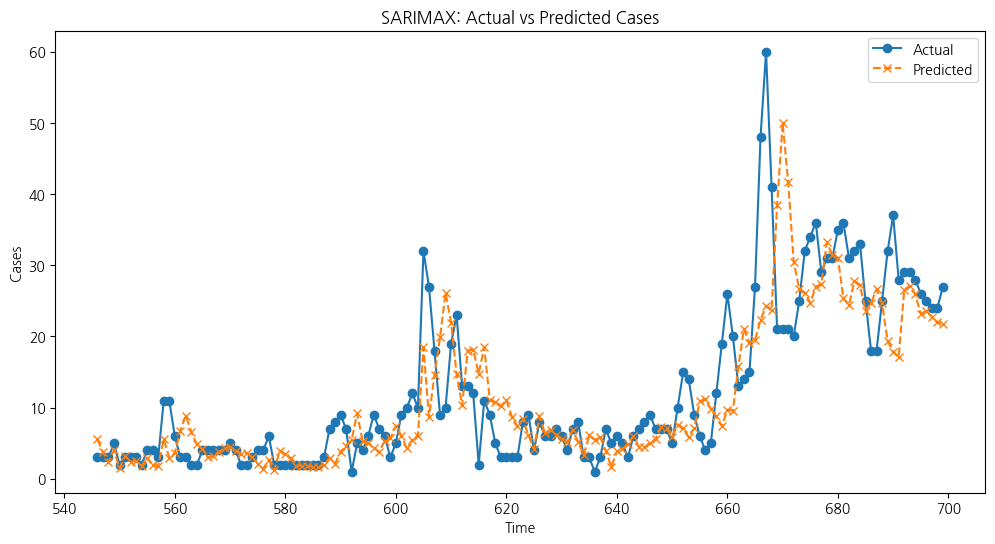

In [ ]:
########################################
# SARIMAX 예측 결과 시각화 및 잔차 분석
########################################
import matplotlib.pyplot as plt

# 실제값과 예측값 시각화 (x축은 인덱스 또는 날짜 사용)
plt.figure(figsize=(12,6))
# 만약 y_test_sar의 인덱스가 날짜라면 그대로 사용 가능
plt.plot(y_test_sar.index, y_test_sar, label='Actual', marker='o', linestyle='-')
plt.plot(y_test_sar.index, pred_sar, label='Predicted', marker='x', linestyle='--')
plt.xlabel("Time")
plt.ylabel("Cases")
plt.title("SARIMAX: Actual vs Predicted Cases")
plt.legend()
plt.show()

In [ ]:
features = original_features

In [ ]:
########################################
# 7. LSTM 예시 (시퀀스 생성)
########################################
lstm_feats = features
X_lstm_arr = df[lstm_feats].values
y_lstm_arr = df['Cases'].values
# 예시: X_lstm_arr 배열에서 nan 값이 있는 위치를 찾기
nan_indices = np.where(np.isnan(X_lstm_arr))
print("nan 값이 있는 인덱스 (행, 열):", nan_indices)

# 열 인덱스만 확인하려면
nan_column_indices = np.unique(nan_indices[1])
print("nan 값이 포함된 열 인덱스:", nan_column_indices)


nan 값이 있는 인덱스 (행, 열): (array([], dtype=int64), array([], dtype=int64))
nan 값이 포함된 열 인덱스: []


In [ ]:
# MinMaxScaler()
scaler_x_lstm = MinMaxScaler()
X_lstm_scaled = scaler_x_lstm.fit_transform(X_lstm_arr)
scaler_y_lstm = MinMaxScaler()
y_lstm_scaled = scaler_y_lstm.fit_transform(y_lstm_arr.reshape(-1,1)).flatten()

window_size = 7
X_lstm_seq, y_lstm_seq = [], []
for i in range(len(X_lstm_scaled) - window_size):
    X_lstm_seq.append(X_lstm_scaled[i:i+window_size])
    y_lstm_seq.append(y_lstm_scaled[i+window_size])
X_lstm_seq = np.array(X_lstm_seq)
y_lstm_seq = np.array(y_lstm_seq)

cut_date_lstm = pd.to_datetime('2021-07-01')
cut_idx_lstm  = df.index[df['Date'] >= cut_date_lstm][0]
split_idx_lstm = max(0, cut_idx_lstm - window_size)

X_train_lstm = X_lstm_seq[:split_idx_lstm]
y_train_lstm = y_lstm_seq[:split_idx_lstm]
X_test_lstm  = X_lstm_seq[split_idx_lstm:]
y_test_lstm_ = y_lstm_seq[split_idx_lstm:]

# LSTM 모델
lstm_model_ = keras.Sequential([
    LSTM(32, activation='tanh', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.2),
    Dense(1)
])
lstm_model_.compile(optimizer='adam', loss='mse')
lstm_model_.summary()

hist_lstm = lstm_model_.fit(
    X_train_lstm, y_train_lstm,
    validation_split=0.2,
    epochs=30, batch_size=16, shuffle=False, verbose=1
)

# 예측
lstm_pred_scaled = lstm_model_.predict(X_test_lstm).flatten()
lstm_pred = scaler_y_lstm.inverse_transform(lstm_pred_scaled.reshape(-1,1)).flatten()
y_test_lstm_ = scaler_y_lstm.inverse_transform(y_test_lstm_.reshape(-1,1)).flatten()

lstm_mae = mean_absolute_error(y_test_lstm_, lstm_pred)
lstm_rmse= np.sqrt(mean_squared_error(y_test_lstm_, lstm_pred))
print("[LSTM] MAE=%.3f, RMSE=%.3f" % (lstm_mae, lstm_rmse))

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                5504      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_19 (Dense)            (None, 1)                 33        
                                                                 
Total params: 5,537
Trainable params: 5,537
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
26/26 [==============================] - 5s 39ms/step - loss: 0.0594 - val_loss: 0.0016
Epoch 2/30
26/26 [==============================] - 0s 16ms/step - loss: 0.0460 - val_loss: 0.0014
Epoch 3/30
26/26 [==============================] - 0s 12ms/step - loss: 0.0334 - val_loss: 0.0010
Epoch 4/30
26/26 [

In [ ]:
def objective(trial):
    # 하이퍼파라미터 탐색
    n_layers = trial.suggest_int('n_layers', 1, 3)
    n_units = trial.suggest_int('n_units', 32, 256)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

    # 모델 구성
    model = keras.Sequential()
    for i in range(n_layers):
        model.add(LSTM(n_units, return_sequences=(i < n_layers-1)))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))

    # 컴파일
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mse')

    # 교차 검증 (TimeSeriesSplit)
    tscv = TimeSeriesSplit(n_splits=3) # 원래는 5로 할려고 했으나 시간이 늘기 때문에...
    val_losses = []

    # 각 Fold마다 모델 학습
    for train_idx, val_idx in tscv.split(X_train_lstm):
        X_tr, X_val = X_train_lstm[train_idx], X_train_lstm[val_idx]
        y_tr, y_val = y_train_lstm[train_idx], y_train_lstm[val_idx]

        # EarlyStopping 콜백 생성: patience=3 (3 에포크 동안 개선 없으면 중단),
        # restore_best_weights=True 옵션으로 중단 시 가장 좋은 가중치 복원
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )

        history = model.fit(
            X_tr, y_tr,
            validation_data=(X_val, y_val),
            epochs=30,
            batch_size=batch_size,
            verbose=0,
            callbacks=[early_stopping]  # EarlyStopping 콜백 추가
        )
        # 각 Fold의 마지막 에포크의 검증 손실을 기록
        val_loss = history.history['val_loss'][-1]
        val_losses.append(val_loss)

    return np.mean(val_losses)

In [ ]:
# Study 생성 및 최적화
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, timeout=3600)  # 아마 50회 정도 실행하는게 좋은 선택 일 것 같다.

# 결과 출력
print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value:.4f}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

'''
Best trial:
  Value: 0.0004
  Params:
    n_layers: 1
    n_units: 199
    dropout_rate: 0.30513674176423294
    lr: 0.004425957246439466
    batch_size: 16
  '''

[I 2025-02-06 02:20:59,539] A new study created in memory with name: no-name-b6dfca46-69f2-46ab-b3ab-959531542a7b
[I 2025-02-06 02:21:24,904] Trial 0 finished with value: 0.000588071663514711 and parameters: {'n_layers': 2, 'n_units': 44, 'dropout_rate': 0.13851286520058861, 'lr': 0.0009397802812387292, 'batch_size': 32}. Best is trial 0 with value: 0.000588071663514711.
[I 2025-02-06 02:21:41,256] Trial 1 finished with value: 0.0005498782217424983 and parameters: {'n_layers': 2, 'n_units': 40, 'dropout_rate': 0.3896448569999822, 'lr': 0.008673592452029791, 'batch_size': 32}. Best is trial 1 with value: 0.0005498782217424983.
[I 2025-02-06 02:21:52,007] Trial 2 finished with value: 0.0007731822164108356 and parameters: {'n_layers': 1, 'n_units': 132, 'dropout_rate': 0.4868970691748544, 'lr': 0.003429589530749838, 'batch_size': 64}. Best is trial 1 with value: 0.0005498782217424983.
[I 2025-02-06 02:22:33,417] Trial 3 finished with value: 0.0006311917386483401 and parameters: {'n_layers

Best trial:
  Value: 0.0004
  Params: 
    n_layers: 1
    n_units: 199
    dropout_rate: 0.30513674176423294
    lr: 0.004425957246439466
    batch_size: 16


In [ ]:


# 최적 파라미터로 최종 모델 학습
best_model = keras.Sequential()
for i in range(trial.params['n_layers']):
    best_model.add(LSTM(trial.params['n_units'],
                      return_sequences=(i < trial.params['n_layers']-1)))
    best_model.add(Dropout(trial.params['dropout_rate']))
best_model.add(Dense(1))

best_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=trial.params['lr']),
    loss='mse'
)

history = best_model.fit(
    X_train_lstm, y_train_lstm,
    epochs=100,  # 충분한 에포크로 재학습
    batch_size=trial.params['batch_size'],
    verbose=1
)

# 테스트 평가
y_pred = best_model.predict(X_test_lstm).flatten()
y_pred = scaler_y_lstm.inverse_transform(y_pred.reshape(-1,1)).flatten()
y_test_orig = scaler_y_lstm.inverse_transform(y_test_lstm_.reshape(-1,1)).flatten()

print(f"MAE: {mean_absolute_error(y_test_orig, y_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_orig, y_pred)):.2f}")

Epoch 1/100
32/32 [==============================] - 9s 42ms/step - loss: 0.0147
Epoch 2/100
32/32 [==============================] - 1s 42ms/step - loss: 7.1368e-04
Epoch 3/100
32/32 [==============================] - 1s 38ms/step - loss: 5.3625e-04
Epoch 4/100
32/32 [==============================] - 1s 41ms/step - loss: 4.5581e-04
Epoch 5/100
32/32 [==============================] - 1s 41ms/step - loss: 4.5587e-04
Epoch 6/100
32/32 [==============================] - 2s 51ms/step - loss: 4.2818e-04
Epoch 7/100
32/32 [==============================] - 1s 45ms/step - loss: 3.5679e-04
Epoch 8/100
32/32 [==============================] - 2s 51ms/step - loss: 3.8125e-04
Epoch 9/100
32/32 [==============================] - 1s 45ms/step - loss: 3.7364e-04
Epoch 10/100
32/32 [==============================] - 1s 43ms/step - loss: 3.7746e-04
Epoch 11/100
32/32 [==============================] - 1s 35ms/step - loss: 3.4959e-04
Epoch 12/100
32/32 [==============================] - 1s 40ms/step 

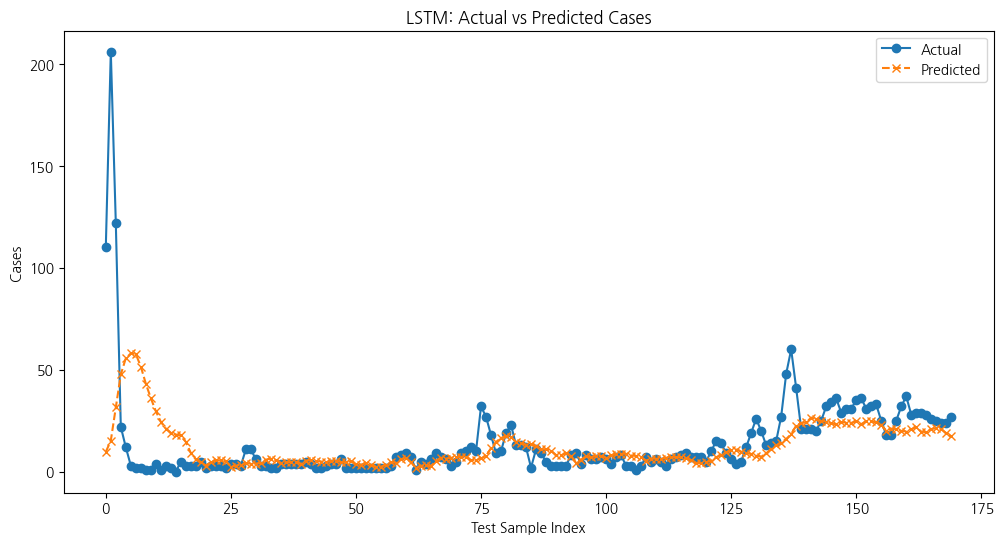

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(range(len(y_test_lstm_)), y_test_lstm_, label='Actual', marker='o', linestyle='-')
plt.plot(range(len(lstm_pred)), lstm_pred, label='Predicted', marker='x', linestyle='--')
plt.xlabel("Test Sample Index")
plt.ylabel("Cases")
plt.title("LSTM: Actual vs Predicted Cases")
plt.legend()
plt.show()

In [ ]:
########################################
# 8. GRU 예시
########################################
# 기존 X_lstm_seq, y_lstm_seq 재사용
gru_model_ = keras.Sequential([
    GRU(32, activation='tanh', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.2),
    Dense(1)
])
gru_model_.compile(optimizer='adam', loss='mse')
gru_model_.summary()

hist_gru = gru_model_.fit(
    X_train_lstm, y_train_lstm,
    validation_split=0.2,
    epochs=30, batch_size=16, shuffle=False, verbose=1
)

gru_pred_scaled = gru_model_.predict(X_test_lstm).flatten()
gru_pred = scaler_y_lstm.inverse_transform(gru_pred_scaled.reshape(-1,1)).flatten()
y_test_gru_ = y_test_lstm_

gru_mae = mean_absolute_error(y_test_gru_, gru_pred)
gru_rmse= np.sqrt(mean_squared_error(y_test_gru_, gru_pred))
print("[GRU] MAE=%.3f, RMSE=%.3f" % (gru_mae, gru_rmse))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 32)                4224      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,257
Trainable params: 4,257
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
26/26 [==============================] - 3s 29ms/step - loss: 0.0104 - val_loss: 0.0091
Epoch 2/30
26/26 [==============================] - 0s 8ms/step - loss: 0.0069 - val_loss: 0.0066
Epoch 3/30
26/26 [==============================] - 0s 8ms/step - loss: 0.0050 - val_loss: 0.0017
Epoch 4/30
26/26 [===

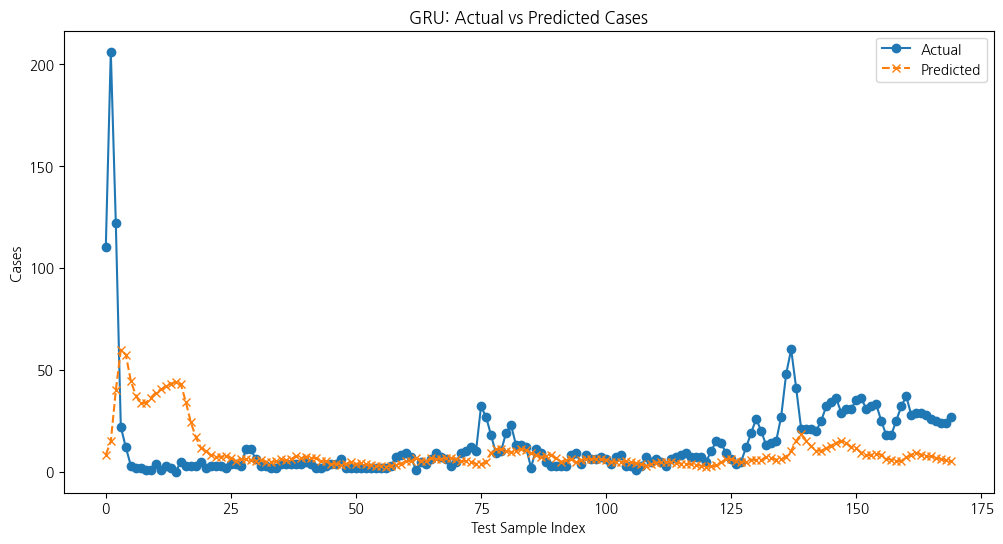

In [ ]:
########################################
# GRU 예측 결과 시각화 및 잔차 분석
########################################
import matplotlib.pyplot as plt

# 예측 결과 (Actual vs Predicted) 시각화
plt.figure(figsize=(12,6))
plt.plot(range(len(y_test_gru_)), y_test_gru_, label='Actual', marker='o', linestyle='-')
plt.plot(range(len(gru_pred)), gru_pred, label='Predicted', marker='x', linestyle='--')
plt.xlabel("Test Sample Index")
plt.ylabel("Cases")
plt.title("GRU: Actual vs Predicted Cases")
plt.legend()
plt.show()

DEBUG:cmdstanpy:input tempfile: /tmp/tmpl7fckntx/ffl83bti.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl7fckntx/i4lfexn5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9448', 'data', 'file=/tmp/tmpl7fckntx/ffl83bti.json', 'init=/tmp/tmpl7fckntx/i4lfexn5.json', 'output', 'file=/tmp/tmpl7fckntx/prophet_modelzlbk4yke/prophet_model-20250206012520.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:25:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:25:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 5 forecasts with cutoffs between 2020-10-03 00:00:00 and 2021-05-31 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7c7378c66650>



[Prophet] MAE=5.895, RMSE=14.914, R2=0.494


DEBUG:cmdstanpy:input tempfile: /tmp/tmpl7fckntx/t5tl18fa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl7fckntx/1jfixwur.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl7fckntx/ksj69cgv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl7fckntx/72t2smqp.json
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34827', 'data', 'file=/tmp/tmpl7fckntx/1jfixwur.json', 'init=/tmp/tmpl7fckntx/ksj69cgv.json', 'output', 'file=/tmp/tmpl7fckntx/prophet_model_m4j1rqn/prophet_model-20250206012521.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
DEBUG:cmdstanpy:idx 0
01:25:21 - cmdstanpy - INFO - Chain [1] start processing
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53417', 'data', 'file=/tmp/tmpl7fckntx/t5tl18fa.json', 


[Prophet CV] 평균 성능:
mae       6.583542
rmse     10.544221
mdape     1.032233
dtype: float64


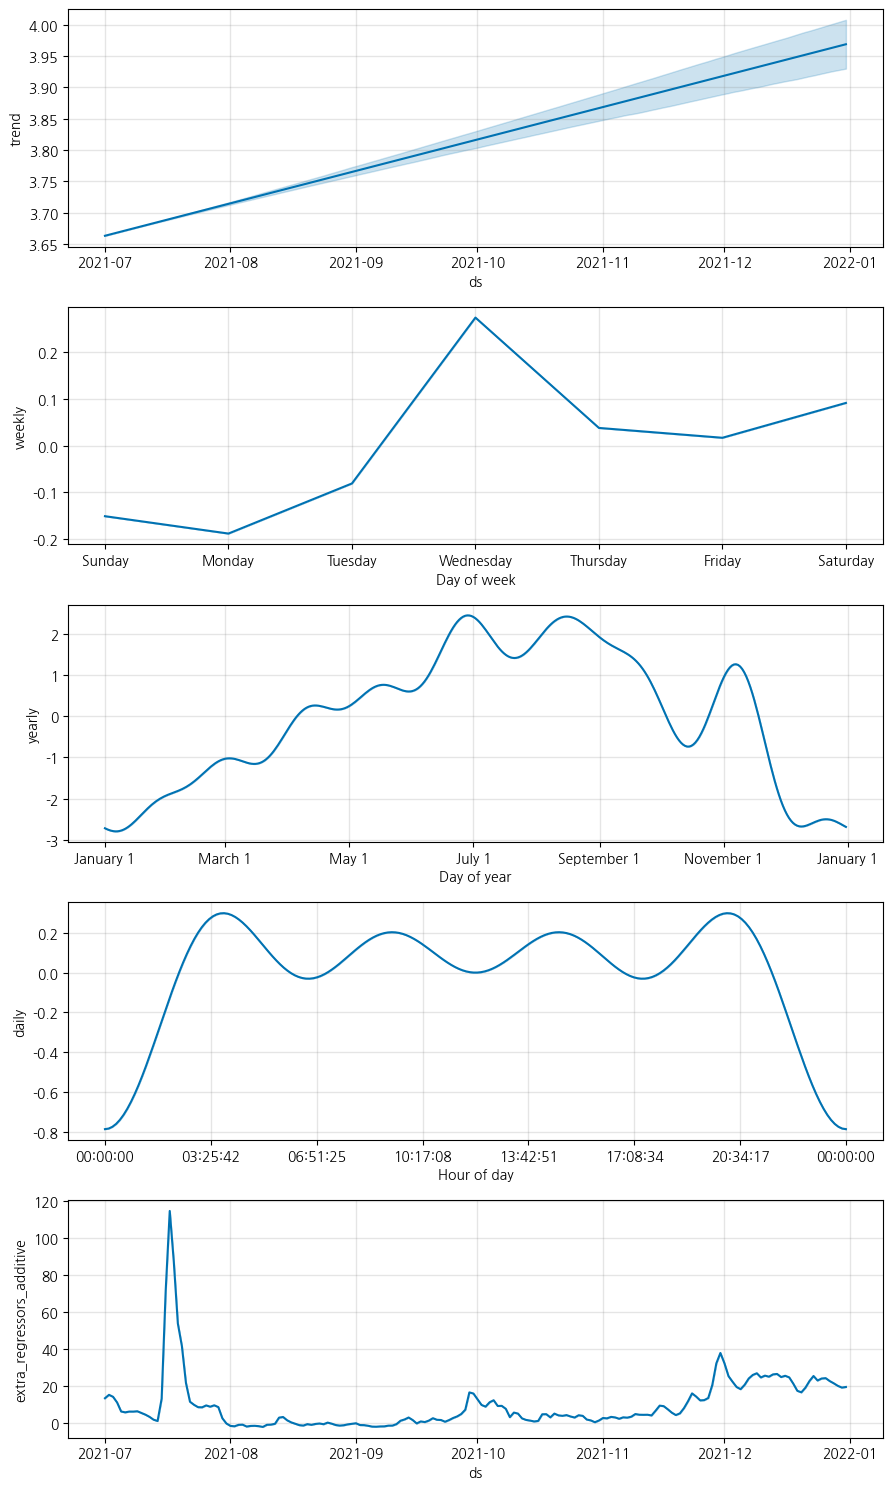

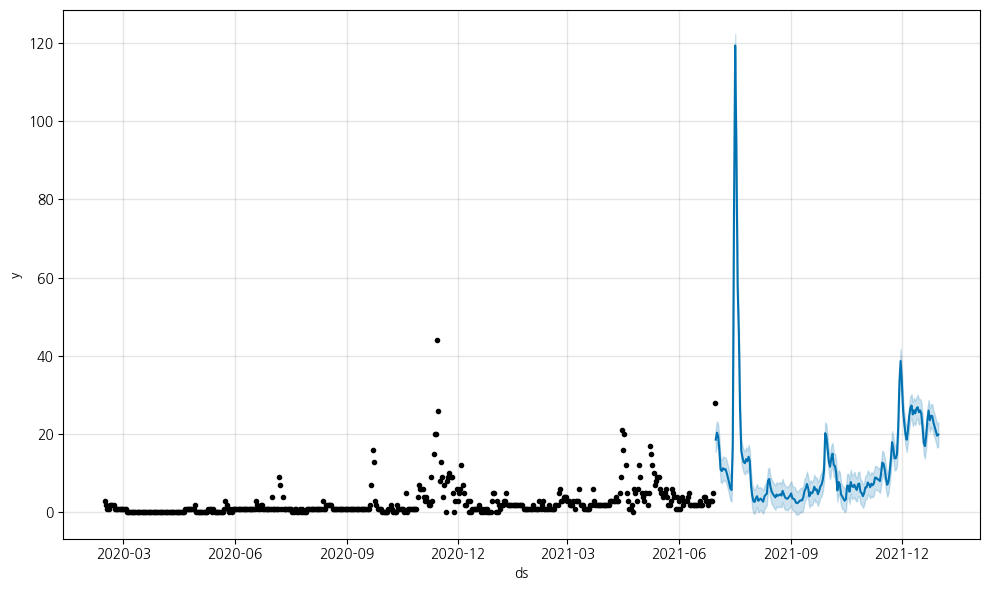

In [ ]:
########################################
# 8. Prophet (Meta의 시계열 예측 모델)
########################################

# 필수 라이브러리 설치 (Colab 등 환경에서)
# !pip install prophet
features = original_features


from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

# 1. 데이터 준비
# Prophet은 'ds'(날짜), 'y'(타겟) 컬럼 필수 + 추가 regressor 컬럼
prophet_df = df[['Date', 'Cases'] + features].copy()  # SARIMAX와 동일 외생변수 사용
prophet_df.columns = ['ds', 'y'] + features  # 컬럼명 변경

# 날짜 기준 train/test 분할 (기존 분할과 일관성 유지)

cut_date_lstm = pd.to_datetime('2021-07-01')
train_prophet = prophet_df[prophet_df['ds'] < cut_date_lstm]
test_prophet = prophet_df[prophet_df['ds'] >= cut_date_lstm]

# 2. 모델 정의 (Hyperparameter 튜닝 예시)
model_prophet = Prophet(
    growth='linear',  # 'linear' 또는 'logistic'
    yearly_seasonality=True,  # 연간 계절성 (데이터 기간이 1년 미만이면 False)
    weekly_seasonality=True,   # 주간 계절성
    daily_seasonality=True,   # 일간 계절성 (일별 데이터 아닌 경우)
    changepoint_prior_scale=0.05,  # 트렌드 변화 민감도 (높을수록 많은 변화점)
    seasonality_mode='additive'   # 'additive' 또는 'multiplicative'
)

# 3. 외생변수(Regressor) 추가
for col in features:
    model_prophet.add_regressor(col)  # 모든 외생변수 등록

# 4. 모델 학습
model_prophet.fit(train_prophet)

# 5. 예측용 Future DataFrame 생성
future = model_prophet.make_future_dataframe(
    periods=len(test_prophet),  # 예측할 기간(테스트셋 길이)
    include_history=False       # 히스토리 포함 여부
)

# 외생변수 추가 (테스트 데이터에서 가져옴)
future[features] = test_prophet[features].values

# 6. 예측 수행
forecast = model_prophet.predict(future)

# 7. 성능 평가
prophet_pred = forecast['yhat'].values
prophet_mae = mean_absolute_error(test_prophet['y'], prophet_pred)
prophet_rmse = np.sqrt(mean_squared_error(test_prophet['y'], prophet_pred))
prophet_r2 = r2_score(test_prophet['y'], prophet_pred)

print("\n[Prophet] MAE=%.3f, RMSE=%.3f, R2=%.3f" %
      (prophet_mae, prophet_rmse, prophet_r2))

# 8. (선택) 교차검증 (시계열 특화)
# 초기 학습 기간 180일, 예측 기간 30일, 평가 간격 60일
df_cv = cross_validation(
    model_prophet,
    initial='180 days',
    period='60 days',
    horizon='30 days',
    parallel="processes"
)

# 교차검증 결과 평균 성능
cv_perf = performance_metrics(df_cv)
print("\n[Prophet CV] 평균 성능:")
print(cv_perf[['mae', 'rmse', 'mdape']].mean())

# 9. 시각화 (트렌드+계절성 분석)
fig1 = model_prophet.plot_components(forecast)
fig2 = model_prophet.plot(forecast)
plt.show()

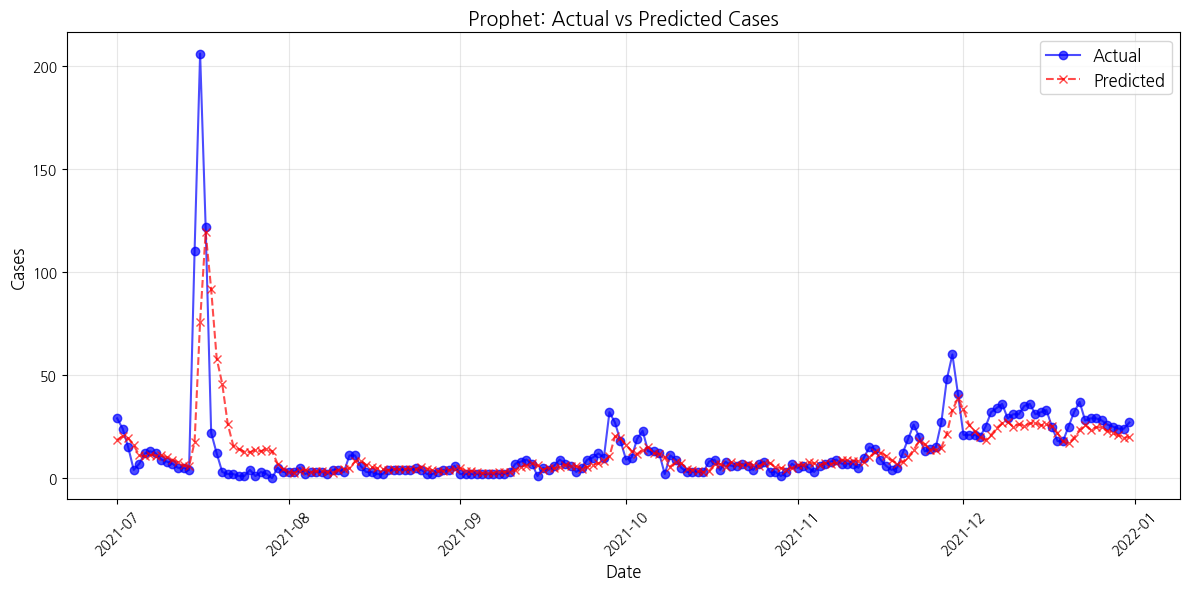

In [ ]:
# 1. 시각화 데이터 준비
test_dates = test_prophet['ds']  # 테스트 기간의 날짜
y_true = test_prophet['y']       # 실제값
y_pred = forecast['yhat']        # 예측값

# 2. 시각화
plt.figure(figsize=(12, 6))

# 실제값 플롯
plt.plot(test_dates, y_true,
         label='Actual',
         marker='o',
         linestyle='-',
         color='blue',
         alpha=0.7)

# 예측값 플롯
plt.plot(test_dates, y_pred,
         label='Predicted',
         marker='x',
         linestyle='--',
         color='red',
         alpha=0.7)

# 그래프 설정
plt.xlabel("Date", fontsize=12)
plt.ylabel("Cases", fontsize=12)
plt.title("Prophet: Actual vs Predicted Cases", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.xticks(rotation=45)  # 날짜 라벨 회전
plt.tight_layout()  # 레이아웃 조정
plt.show()

In [ ]:
########################################
# 9. 앙상블 (단순 가중/Stacking 등)
########################################
# 예시: RandomForest, SARIMAX, LSTM, GRU 결과
# 실제로는 시점 맞춰서, min_len 등 처리 필요
from xgboost import XGBRegressor
min_len_ = min(len(y_test_rf), len(pred_sar), len(lstm_pred), len(gru_pred))
stack_X = np.column_stack([
    y_pred_rf[-min_len_:],
    pred_sar[-min_len_:],
    lstm_pred[-min_len_:],
    gru_pred[-min_len_:]
])
stack_y = y_test_rf.values[-min_len_:]  # RF기준, 필요시 조정

stack_imputer = SimpleImputer(strategy='mean')
stack_X_ = stack_imputer.fit_transform(stack_X)

stack_final = XGBRegressor()
stack_final.fit(stack_X_, stack_y)
stack_pred = stack_final.predict(stack_X_)

stack_mae = mean_absolute_error(stack_y, stack_pred)
stack_rmse= np.sqrt(mean_squared_error(stack_y, stack_pred))
print("[Stacking Ensemble] MAE=%.3f, RMSE=%.3f" % (stack_mae, stack_rmse))

[Stacking Ensemble] MAE=0.002, RMSE=0.003


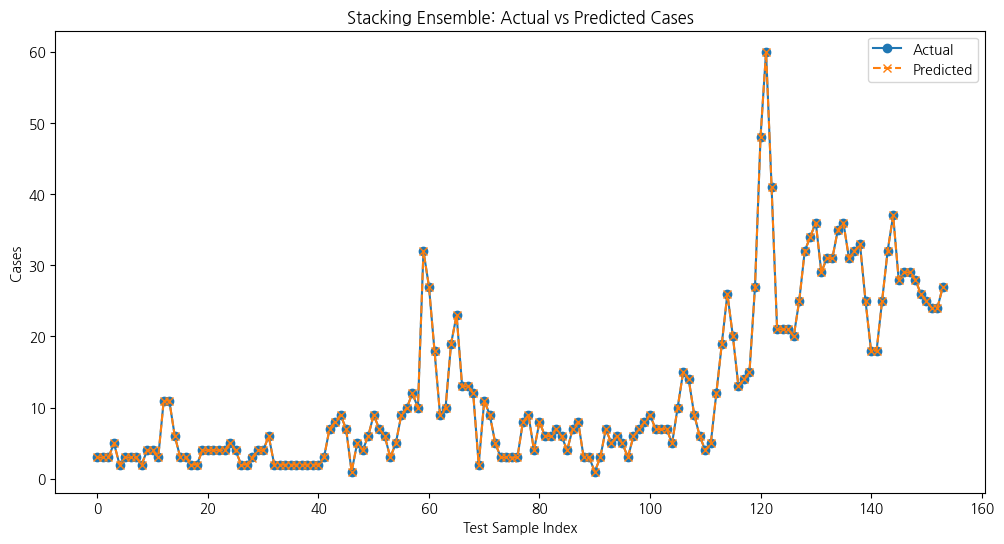

In [ ]:
# 예측 결과 시각화: 실제값과 앙상블 예측값 비교
plt.figure(figsize=(12,6))
plt.plot(range(len(stack_y)), stack_y, label='Actual', marker='o', linestyle='-')
plt.plot(range(len(stack_pred)), stack_pred, label='Predicted', marker='x', linestyle='--')
plt.xlabel("Test Sample Index")
plt.ylabel("Cases")
plt.title("Stacking Ensemble: Actual vs Predicted Cases")
plt.legend()
plt.show()

In [ ]:
########################################
# 10. 기타 (TCN, Optuna)
########################################
# 예시: TCN 하이퍼파라미터 최적화 (간단)
# (이미 user code 참고)

# 시퀀스 데이터 생성 (window_size=14)
lstm_features = features
X_arr = df[lstm_features].values
y_arr = df['Cases'].values

# 스케일링 (차분 데이터용 새 스케일러 생성)
scaler_X_diff = StandardScaler()
X_scaled_diff = scaler_X_diff.fit_transform(X_arr)

scaler_y_diff = StandardScaler()
y_scaled_diff = scaler_y_diff.fit_transform(y_arr.reshape(-1,1)).flatten()

# 시퀀스 데이터 생성 (window_size=14)
window_size = 14
X_seq_list, y_seq_list = [], []
for i in range(len(X_scaled_diff) - window_size):
    X_seq_list.append(X_scaled_diff[i:i+window_size])
    y_seq_list.append(y_scaled_diff[i+window_size])
X_seq = np.array(X_seq_list)
y_seq = np.array(y_seq_list)


In [ ]:
X_data = df[features].values
y_data = df["Cases"].values

# 7) 스케일링
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_data)
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y_data.reshape(-1,1)).flatten()

In [ ]:
window_size = 14
X_seq_list, y_seq_list = [], []
for i in range(len(X_scaled) - window_size):
    X_seq_list.append(X_scaled[i : i + window_size])
    y_seq_list.append(y_scaled[i + window_size])
X_seq = np.array(X_seq_list)
y_seq = np.array(y_seq_list)

In [ ]:
tscv = TimeSeriesSplit(n_splits=3)

In [ ]:
from tensorflow.keras.models import clone_model
def objective(trial):
    nb_filters_ = trial.suggest_int("nb_filters", 32, 128, step=32)
    kernel_ = trial.suggest_int("kernel_size", 2, 5)
    dilations_ = trial.suggest_categorical("dilations", [[1,2],[1,2,4],[1,2,4,8]])
    dropout_ = trial.suggest_float("dropout", 0.0, 0.3, step=0.1)
    lr_ = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    num_layers_ = trial.suggest_int("num_layers", 1, 2)
    batch_size_ = trial.suggest_categorical("batch_size", [16, 32, 64])

    base_model = Sequential()
    base_model.add(InputLayer(input_shape=(X_seq.shape[1], X_seq.shape[2])))
    if num_layers_ == 1:
        base_model.add(
            TCN(
                nb_filters=nb_filters_,
                kernel_size=kernel_,
                dilations=dilations_,
                dropout_rate=dropout_,
                return_sequences=False
            )
        )
    else:
        base_model.add(
            TCN(
                nb_filters=nb_filters_,
                kernel_size=kernel_,
                dilations=dilations_,
                dropout_rate=dropout_,
                return_sequences=True
            )
        )
        base_model.add(
            TCN(
                nb_filters=nb_filters_,
                kernel_size=kernel_,
                dilations=dilations_,
                dropout_rate=dropout_,
                return_sequences=False
            )
        )
    base_model.add(Dense(1))

    cv_losses = []
    for train_idx, val_idx in tscv.split(X_seq):
        X_train_cv, X_val_cv = X_seq[train_idx], X_seq[val_idx]
        y_train_cv, y_val_cv = y_seq[train_idx], y_seq[val_idx]
        model_cv = clone_model(base_model)
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_)
        model_cv.compile(optimizer=optimizer, loss="mse")
        model_cv.fit(
            X_train_cv, y_train_cv,
            validation_data=(X_val_cv, y_val_cv),
            epochs=10,
            batch_size=batch_size_,
            verbose=0,
            shuffle=False
        )
        val_pred = model_cv.predict(X_val_cv)
        mse_ = mean_squared_error(y_val_cv, val_pred)
        cv_losses.append(mse_)

    return np.mean(cv_losses)

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20, timeout=600)

best_trial = study.best_trial
best_params = best_trial.params

[I 2025-02-06 01:26:05,654] A new study created in memory with name: no-name-a95aaf47-fe19-47b6-a806-8eee9cd662d6
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2, 4] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2, 4, 8] which is of type list.
  warnings.warn(message)


6/6 [==============================] - 1s 22ms/step


[I 2025-02-06 01:27:14,494] Trial 0 finished with value: 1.9475786747442598 and parameters: {'nb_filters': 128, 'kernel_size': 5, 'dilations': [1, 2, 4], 'dropout': 0.3, 'lr': 0.0001340642133262649, 'num_layers': 2, 'batch_size': 32}. Best is trial 0 with value: 1.9475786747442598.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2, 4] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persisten

6/6 [==============================] - 0s 6ms/step


[I 2025-02-06 01:27:35,935] Trial 1 finished with value: 2.498599942014226 and parameters: {'nb_filters': 96, 'kernel_size': 2, 'dilations': [1, 2, 4], 'dropout': 0.0, 'lr': 0.0007752693226744083, 'num_layers': 1, 'batch_size': 64}. Best is trial 0 with value: 1.9475786747442598.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2, 4] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent 

6/6 [==============================] - 0s 11ms/step


[I 2025-02-06 01:28:11,747] Trial 2 finished with value: 1.4707285896996476 and parameters: {'nb_filters': 64, 'kernel_size': 5, 'dilations': [1, 2, 4], 'dropout': 0.0, 'lr': 0.0006717773412468408, 'num_layers': 2, 'batch_size': 32}. Best is trial 2 with value: 1.4707285896996476.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2, 4] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent

6/6 [==============================] - 0s 7ms/step


[I 2025-02-06 01:28:38,863] Trial 3 finished with value: 1.3291617706316223 and parameters: {'nb_filters': 96, 'kernel_size': 2, 'dilations': [1, 2], 'dropout': 0.0, 'lr': 0.0020163108403603272, 'num_layers': 2, 'batch_size': 64}. Best is trial 3 with value: 1.3291617706316223.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2, 4] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent st

6/6 [==============================] - 0s 12ms/step


[I 2025-02-06 01:29:25,044] Trial 4 finished with value: 1.6207373697608987 and parameters: {'nb_filters': 96, 'kernel_size': 5, 'dilations': [1, 2, 4, 8], 'dropout': 0.3, 'lr': 0.0031489474939527494, 'num_layers': 1, 'batch_size': 16}. Best is trial 3 with value: 1.3291617706316223.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2, 4] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persist

6/6 [==============================] - 1s 13ms/step


[I 2025-02-06 01:29:49,933] Trial 5 finished with value: 1.6035228760633362 and parameters: {'nb_filters': 32, 'kernel_size': 2, 'dilations': [1, 2, 4, 8], 'dropout': 0.3, 'lr': 0.005801732471051276, 'num_layers': 1, 'batch_size': 32}. Best is trial 3 with value: 1.3291617706316223.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2, 4] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persiste

6/6 [==============================] - 1s 15ms/step


[I 2025-02-06 01:30:58,335] Trial 6 finished with value: 1.7601042288660864 and parameters: {'nb_filters': 64, 'kernel_size': 5, 'dilations': [1, 2, 4, 8], 'dropout': 0.1, 'lr': 0.00019119069566432564, 'num_layers': 2, 'batch_size': 16}. Best is trial 3 with value: 1.3291617706316223.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2, 4] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persis

6/6 [==============================] - 0s 5ms/step


[I 2025-02-06 01:31:20,827] Trial 7 finished with value: 10.53489072489957 and parameters: {'nb_filters': 32, 'kernel_size': 5, 'dilations': [1, 2, 4], 'dropout': 0.3, 'lr': 0.006349256470100449, 'num_layers': 1, 'batch_size': 32}. Best is trial 3 with value: 1.3291617706316223.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2, 4] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent s

6/6 [==============================] - 1s 14ms/step


[I 2025-02-06 01:32:01,590] Trial 8 finished with value: 9.571508785336114 and parameters: {'nb_filters': 32, 'kernel_size': 2, 'dilations': [1, 2, 4, 8], 'dropout': 0.1, 'lr': 0.00023341520371697694, 'num_layers': 2, 'batch_size': 32}. Best is trial 3 with value: 1.3291617706316223.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2, 4] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persist

6/6 [==============================] - 0s 8ms/step


[I 2025-02-06 01:32:40,280] Trial 9 finished with value: 3.682920611154316 and parameters: {'nb_filters': 64, 'kernel_size': 2, 'dilations': [1, 2, 4], 'dropout': 0.0, 'lr': 0.0008309665058267266, 'num_layers': 2, 'batch_size': 16}. Best is trial 3 with value: 1.3291617706316223.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2, 4] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent 

6/6 [==============================] - 0s 11ms/step


[I 2025-02-06 01:33:18,310] Trial 10 finished with value: 1.344677121713924 and parameters: {'nb_filters': 128, 'kernel_size': 3, 'dilations': [1, 2], 'dropout': 0.2, 'lr': 0.001976787008316481, 'num_layers': 2, 'batch_size': 64}. Best is trial 3 with value: 1.3291617706316223.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2, 4] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent st

6/6 [==============================] - 0s 11ms/step


[I 2025-02-06 01:33:58,459] Trial 11 finished with value: 1.3892379483676445 and parameters: {'nb_filters': 128, 'kernel_size': 3, 'dilations': [1, 2], 'dropout': 0.2, 'lr': 0.0019505252833803789, 'num_layers': 2, 'batch_size': 64}. Best is trial 3 with value: 1.3291617706316223.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2, 4] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent 

6/6 [==============================] - 0s 11ms/step


[I 2025-02-06 01:34:36,004] Trial 12 finished with value: 1.3485084641241494 and parameters: {'nb_filters': 128, 'kernel_size': 3, 'dilations': [1, 2], 'dropout': 0.2, 'lr': 0.001745490445720014, 'num_layers': 2, 'batch_size': 64}. Best is trial 3 with value: 1.3291617706316223.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2, 4] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent s

6/6 [==============================] - 0s 8ms/step


[I 2025-02-06 01:35:07,704] Trial 13 finished with value: 1.3436776499997627 and parameters: {'nb_filters': 96, 'kernel_size': 3, 'dilations': [1, 2], 'dropout': 0.1, 'lr': 0.003006076661188299, 'num_layers': 2, 'batch_size': 64}. Best is trial 3 with value: 1.3291617706316223.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2, 4] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent st

6/6 [==============================] - 0s 9ms/step


[I 2025-02-06 01:35:42,252] Trial 14 finished with value: 1.4920586875944937 and parameters: {'nb_filters': 96, 'kernel_size': 4, 'dilations': [1, 2], 'dropout': 0.1, 'lr': 0.009943619945372843, 'num_layers': 2, 'batch_size': 64}. Best is trial 3 with value: 1.3291617706316223.
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2, 4] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent st

6/6 [==============================] - 0s 9ms/step


[I 2025-02-06 01:36:11,329] Trial 15 finished with value: 1.9757308073533488 and parameters: {'nb_filters': 96, 'kernel_size': 4, 'dilations': [1, 2], 'dropout': 0.0, 'lr': 0.003419198866839183, 'num_layers': 2, 'batch_size': 64}. Best is trial 3 with value: 1.3291617706316223.


In [ ]:
# 최적 모델 빌드
nb_filters_best = best_params["nb_filters"]
kernel_best = best_params["kernel_size"]
dilations_best = best_params["dilations"]
dropout_best = best_params["dropout"]
lr_best = best_params["lr"]
num_layers_best = best_params["num_layers"]
batch_size_best = best_params["batch_size"]

In [ ]:
final_model = Sequential()
final_model.add(InputLayer(input_shape=(X_seq.shape[1], X_seq.shape[2])))
if num_layers_best == 1:
    final_model.add(
        TCN(
            nb_filters=nb_filters_best,
            kernel_size=kernel_best,
            dilations=dilations_best,
            dropout_rate=dropout_best,
            return_sequences=False
        )
    )
else:
    final_model.add(
        TCN(
            nb_filters=nb_filters_best,
            kernel_size=kernel_best,
            dilations=dilations_best,
            dropout_rate=dropout_best,
            return_sequences=True
        )
    )
    final_model.add(
        TCN(
            nb_filters=nb_filters_best,
            kernel_size=kernel_best,
            dilations=dilations_best,
            dropout_rate=dropout_best,
            return_sequences=False
        )
    )
final_model.add(Dense(1))

final_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_best)
final_model.compile(optimizer=final_optimizer, loss="mse")

In [ ]:
# 12) 훈련/테스트 분할 (8:2)
split_ratio = 0.8
split_idx = int(len(X_seq) * split_ratio)
X_train_final, X_test_final = X_seq[:split_idx], X_seq[split_idx:]
y_train_final, y_test_final = y_seq[:split_idx], y_seq[split_idx:]

history_final = final_model.fit(
    X_train_final, y_train_final,
    validation_split=0.2,
    epochs=20,
    batch_size=batch_size_best,
    shuffle=False,
    verbose=1
)

# 13) 평가
y_pred_final = final_model.predict(X_test_final)
mse_final = mean_squared_error(y_test_final, y_pred_final)
rmse_final = np.sqrt(mse_final)
mae_final = mean_absolute_error(y_test_final, y_pred_final)
r2_final = r2_score(y_test_final, y_pred_final)

print("\n=== Best Hyperparameters ===")
print(best_params)
print("=== Final Performance ===")
print(f"MSE:  {mse_final:.4f}")
print(f"RMSE: {rmse_final:.4f}")
print(f"MAE:  {mae_final:.4f}")
print(f"R2:   {r2_final:.4f}")

Epoch 1/20
7/7 [==============================] - 4s 106ms/step - loss: 21.3019 - val_loss: 19.6975
Epoch 2/20
7/7 [==============================] - 0s 43ms/step - loss: 6.6978 - val_loss: 5.1241
Epoch 3/20
7/7 [==============================] - 0s 44ms/step - loss: 2.6978 - val_loss: 5.9404
Epoch 4/20
7/7 [==============================] - 0s 43ms/step - loss: 3.2969 - val_loss: 7.5771
Epoch 5/20
7/7 [==============================] - 0s 46ms/step - loss: 0.9013 - val_loss: 5.7565
Epoch 6/20
7/7 [==============================] - 0s 46ms/step - loss: 0.3203 - val_loss: 4.9289
Epoch 7/20
7/7 [==============================] - 0s 44ms/step - loss: 0.1908 - val_loss: 5.0699
Epoch 8/20
7/7 [==============================] - 0s 44ms/step - loss: 0.1423 - val_loss: 5.0997
Epoch 9/20
7/7 [==============================] - 0s 52ms/step - loss: 0.1124 - val_loss: 4.9578
Epoch 10/20
7/7 [==============================] - 0s 41ms/step - loss: 0.1096 - val_loss: 4.9254
Epoch 11/20
7/7 [=========

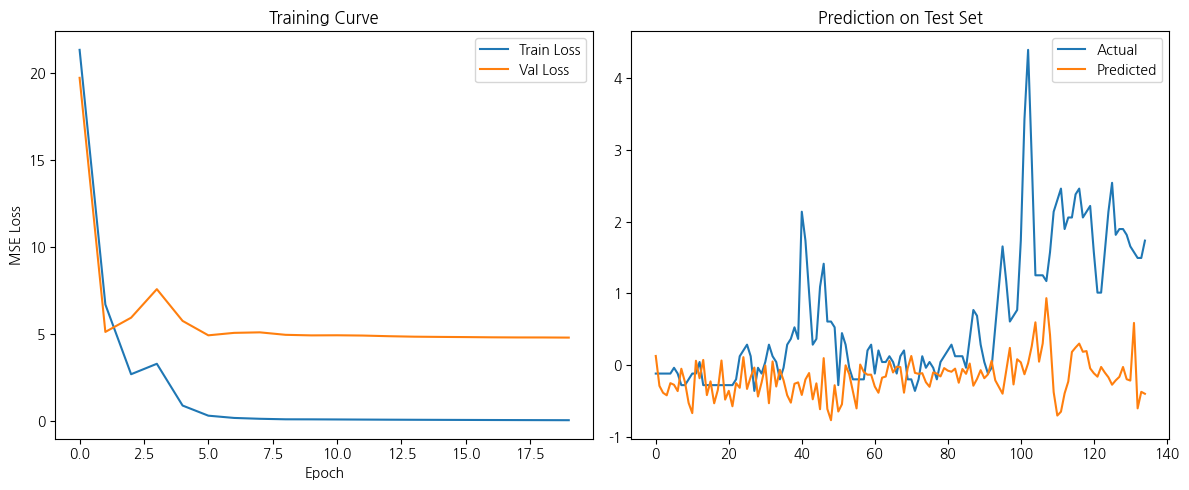

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_final.history["loss"], label="Train Loss")
plt.plot(history_final.history["val_loss"], label="Val Loss")
plt.title("Training Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(len(y_test_final)), y_test_final, label="Actual")
plt.plot(range(len(y_test_final)), y_pred_final, label="Predicted")
plt.title("Prediction on Test Set")
plt.legend()

plt.tight_layout()
plt.show()

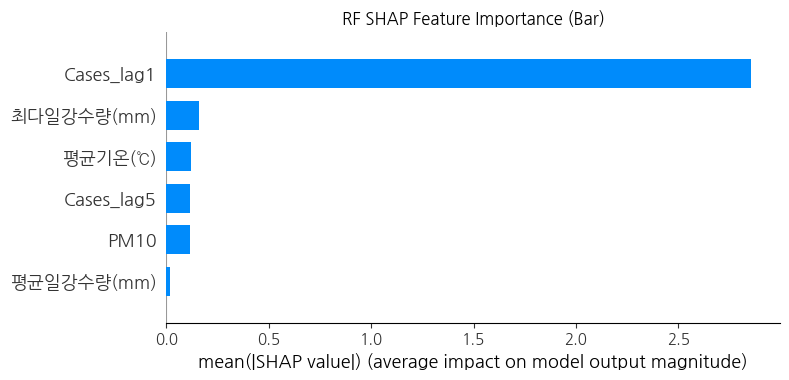

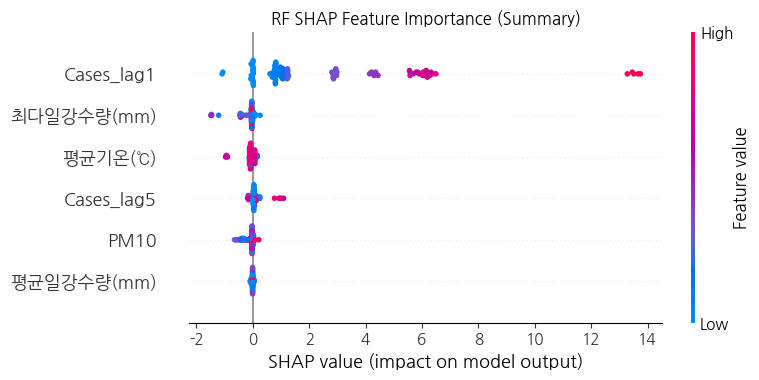

In [ ]:
########################################
# 14. SHAP 분석 (예시)
########################################

"""
각 모델별로 SHAP 값을 분석하여 Feature 중요도를 도출할 수 있습니다.

[RandomForest]의 경우 TreeExplainer 사용,
[LSTM/GRU/TCN]은 DeepExplainer 또는 GradientExplainer 등을 사용할 수 있으나,
시계열 RNN류 모델은 SHAP 분석 시 input dimension 문제로 간단하지 않습니다.


"""


# 4-1) RandomForest SHAP 분석
explainer_rf = shap.TreeExplainer(best_rf)
X_test_sample = X_test_rf.iloc[:100].copy()

shap_values_rf = explainer_rf.shap_values(X_test_sample)

# 시각화
plt.figure(figsize=(10,6))
shap.summary_plot(shap_values_rf, X_test_sample, plot_type="bar", show=False)
plt.title("RF SHAP Feature Importance (Bar)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
shap.summary_plot(shap_values_rf, X_test_sample, show=False)
plt.title("RF SHAP Feature Importance (Summary)")
plt.tight_layout()
plt.show()

In [ ]:
# import numpy as np
# import shap
# import matplotlib.pyplot as plt

# # 4-2) LSTM SHAP 분석 (단순화된 예시)
# X_test_lstm_2d = X_test_lstm.reshape(X_test_lstm.shape[0], -1)[:50]
# window_size = 7

# # (1) LSTM 예측 함수를 수정해, 단일 시점 혹은 단일 값만 나오도록 조정
# def lstm_predict_2d(x_2d):
#     x_3d = x_2d.reshape(-1, window_size, X_test_lstm.shape[2])
#     y_pred = lstm_model_.predict(x_3d)  # 예: (N, 5) shape
#     y_pred = y_pred[:, 0]  # 원하는 타깃(예: 첫 번째 출력) 선택 → (N,) shape
#     return y_pred

# print("X_test_lstm.shape:", X_test_lstm.shape)
# print("window_size:", window_size)

# # (2) background 데이터 171개 (전체 샘플)를 사용
# # X_test_lstm_2d = X_test_lstm.reshape(X_test_lstm.shape[0], -1)
# # background = X_test_lstm_2d  # 원래 (171, 196)
# # print("background.shape (before):", background.shape)

# # # 배경 데이터의 샘플 수가 피처 수보다 작으면 복제해서 늘리기
# # n_samples, n_features = background.shape
# # if n_samples <= n_features:
# #     # 필요한 최소 샘플 수: n_features + 1
# #     required = n_features + 1
# #     repeat_factor = int(np.ceil(required / n_samples))
# #     background = np.tile(background, (repeat_factor, 1))
# #     print("background.shape (after tiling):", background.shape)
# # (2) Increase background data samples: Replicate existing samples to meet requirement
# X_test_lstm_2d = X_test_lstm.reshape(X_test_lstm.shape[0], -1)
# background = X_test_lstm_2d  # 원래 (171, 196)
# print("background.shape (before):", background.shape)

# # Increase background data size by replicating it multiple times
# # Aim for at least n_features + 1 samples
# n_samples, n_features = background.shape
# replication_factor = int(np.ceil((n_features + 1) / n_samples))
# # Calculate factor to replicate data enough times
# background = np.tile(background, (replication_factor, 1))
# # Replicate background data
# print("background.shape (after tiling):", background.shape)
# temp_pred = lstm_predict_2d(background)
# print("temp_pred.shape:", temp_pred.shape)


# # (3) KernelExplainer에 배경 데이터와 예측 함수를 연결
# # l1_reg 값은 데이터에 맞게 조정하세요. 여기서는 예시로 2를 사용합니다.
# explainer_lstm = shap.KernelExplainer(lstm_predict_2d, background, l1_reg=3)

# # (4) 설명을 구하고 싶은 대상(여기서는 전체 X_test_lstm_2d)을 넣기
# shap_values_lstm = explainer_lstm.shap_values(X_test_lstm_2d, nsamples=50)

# # (5) 시각화
# plt.figure(figsize=(10,6))
# shap.summary_plot(
#     shap_values_lstm,
#     X_test_lstm_2d,
#     feature_names=[f'{i//window_size}_t-{window_size - i%window_size}'
#                    for i in range(X_test_lstm_2d.shape[1])],
#     plot_type="bar",
#     show=False
# )
# plt.title("LSTM SHAP Feature Importance (Flattened Time Steps)")
# plt.tight_layout()
# plt.show()


X_test_lstm.shape: (171, 7, 28)
window_size: 7
background.shape (before): (171, 196)
background.shape (after tiling): (342, 196)
11/11 [==============================] - 0s 3ms/step
temp_pred.shape: (342,)
11/11 [==============================] - 0s 3ms/step


  0%|          | 0/171 [00:00<?, ?it/s]

535/535 [==============================] - 1s 2ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:753: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 13 iterations, alpha=1.060e-03, previous alpha=1.026e-03, with an active set of 8 regressors.
  warnings.warn(


ValueError: You are using LassoLarsIC in the case where the number of samples is smaller than the number of features. In this setting, getting a good estimate for the variance of the noise is not possible. Provide an estimate of the noise variance in the constructor.

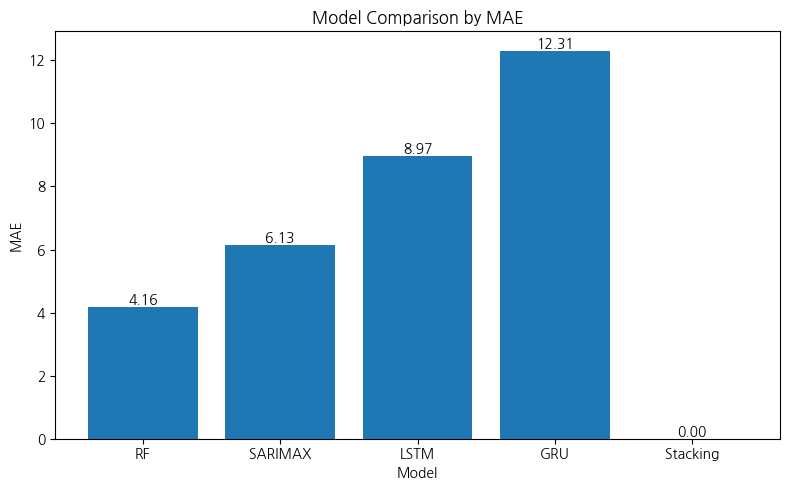

In [ ]:
########################################
# 11. 결과 비교 시각화
########################################
model_names = ['RF','SARIMAX','LSTM','GRU','Stacking']
mae_list = [rf_mae, sar_mae, lstm_mae, gru_mae, stack_mae]

plt.figure(figsize=(8,5))
bars = plt.bar(model_names, mae_list)
plt.title("Model Comparison by MAE")
plt.xlabel("Model")
plt.ylabel("MAE")
for b in bars:
    h = b.get_height()
    plt.text(b.get_x()+b.get_width()/2., h, f"{h:.2f}", ha='center', va='bottom')
plt.tight_layout()
plt.show()

In [ ]:
########################################
# 12. 리소스 정리
########################################
del X_lstm_scaled, y_lstm_scaled
gc.collect()

print("\n=== ALL DONE ===")


=== ALL DONE ===
